<a href="https://colab.research.google.com/github/adlihs/instatXML/blob/main/Visualizaciones_Qatar_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mplsoccer
!pip install -U pandasql
!pip install highlight-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 2.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26787 sha256=5d381ff68c51924f2d42cb048fe421e041869d7c0ba063ad62ad5c5aaf654f71
  Stored in directory: /root/.cache/pip/wheels/ed/8f/46/a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff
Successfully built pandasql
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Setup pandasql

In [ ]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

## Import packages

In [ ]:
import os, sys 
#to be able to interact with Google Drive's operating system
from google.colab import drive 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba,LinearSegmentedColormap
from urllib.request import urlopen
from PIL import Image
from mplsoccer import Pitch,VerticalPitch, FontManager, Sbopen, add_image,PyPizza
from highlight_text import HighlightText, ax_text, fig_text
import matplotlib.patheffects as path_effects
import re
import warnings

## Load fonts

In [ ]:
import matplotlib as mpl
import matplotlib.font_manager as fm

#!mv /content/drive/MyDrive/fonts/Comfortaa-Bold.ttf /usr/share/fonts/truetype/

path = '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf' #'/usr/share/fonts/truetype/Oswald-Bold.ttf'
fontprop = fm.FontProperties(fname=path, size= 35)
game_det_fontprop = fm.FontProperties(fname=path, size=20)
title_det_fontprop = fm.FontProperties(fname=path, size=15)


## Load Instat data

In [ ]:
tournament = input('Enter tournament (Qatar2022): ')

if tournament == 'Qatar2022':
  %cd '/content/drive/MyDrive/Qatar2022/Datos'
  main_df = pd.read_parquet('Qatar 2022.parquet')
  main_df.query("Acciones != 'Ataques posicionales'",inplace=True) 
  main_df['jugador'] = main_df['jugador'].str.strip()

main_df.head()

Enter tournament (Qatar2022): Qatar2022
/content/drive/MyDrive/Qatar2022/Datos


ID      start    end pos_x pos_y            Partido camisa  \
0  1  28.140625  48.14  52.5  34.0  Qatar-0-2-Ecuador     19   
1  2  28.140625  48.14  52.5  34.0  Qatar-0-2-Ecuador     19   
2  3  28.703125  48.71  50.6  33.8  Qatar-0-2-Ecuador     11   
3  4  30.218750  50.22  46.5  33.8  Qatar-0-2-Ecuador     11   
4  5  30.218750  50.22  46.5  33.8  Qatar-0-2-Ecuador     11   

                                   jugador Equipos              Acciones  ...  \
0             Almoez Ali Zainalabiddin Ali   Qatar  Tiros libres a favor  ...   
1             Almoez Ali Zainalabiddin Ali   Qatar        Pases precisos  ...   
2  Akram Hassan Afif Yahya Afif Yahya Afif   Qatar  Tiros libres a favor  ...   
3  Akram Hassan Afif Yahya Afif Yahya Afif   Qatar  Tiros libres a favor  ...   
4  Akram Hassan Afif Yahya Afif Yahya Afif   Qatar        Pases precisos  ...   

  nombre_torneo equipo_casa equipo_visita marcador goles_local goles_visita  \
0    Qatar 2022       Qatar       Ecuador      0-2           0            2   
1    Qatar 2022       Qatar       Ecuador      0-2           0            2   
2    Qatar 2022       Qatar       Ecuador      0-2           0            2   
3    Qatar 2022       Qatar       Ecuador      0-2           0            2   
4    Qatar 2022       Qatar       Ecuador      0-2           0            2   

     rival marcador_casa marcador_visita  detalle_marcador  
0  Ecuador           0.0             0.0               0-0  
1  Ecuador           0.0             0.0               0-0  
2  Ecuador           0.0             0.0               0-0  
3  Ecuador           0.0             0.0               0-0  
4  Ecuador           0.0             0.0               0-0  

[5 rows x 22 columns]

## Player images

### Function

In [ ]:
def player_images(player):
  return  Image.open(player)
 

### Example

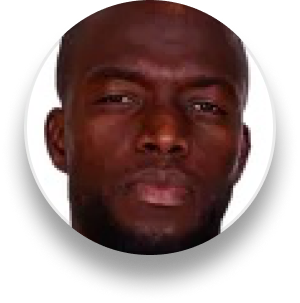

In [ ]:
player_images('/content/drive/MyDrive/Qatar2022/jugadores/imagenes/Ecuador/Enner Valencia.png')

## Get teams starting lineups by game

In [ ]:
#main_df = main_df.query("jugador != ' Aaron Moises Cruz Esquivel' ")
#main_df['jugador'].unique()

In [ ]:
def get_lineups(instat_data):
  main_df = instat_data
  '''
  Process to identify the startup lineup by games and teams
  '''
  # Get the minimum ID of player's action
  #query = "SELECT  Partido, Equipos, camisa, jugador, min(ID) as 'min_id' FROM main_df WHERE Partido = '{}' GROUP BY Partido, Equipos, camisa, jugador".format(game)
  query = "SELECT  Partido, Equipos, camisa, jugador, min(ID) as 'min_id' FROM main_df GROUP BY Partido, Equipos, camisa, jugador"
  lineup_df = pysqldf(query) 
  lineup_df['min_id'] = pd.to_numeric(lineup_df['min_id'])
  
  #Get the list of games
  partidos = lineup_df['Partido'].unique()


  lineups_data = pd.DataFrame()
  for game in partidos:
    temp_df = lineup_df.query("Partido == @game")
    teams_temp_df = temp_df['Equipos'].unique()
    for teams in teams_temp_df:
      temp_df = lineup_df.query("Partido == @game and Equipos == @teams")
      temp_lineup = temp_df.nsmallest(n=11, columns=['min_id'], keep='last')
      lineups_data = lineups_data.append(temp_lineup) 
  return lineups_data

## Filter main dataframe with important columns

In [ ]:
pass_df = main_df[['ID','start','end','pos_x','pos_y','Partido','camisa','jugador','Equipos','Acciones']]
pass_df.head()

ID      start    end pos_x pos_y            Partido camisa  \
0  1  28.140625  48.14  52.5  34.0  Qatar-0-2-Ecuador     19   
1  2  28.140625  48.14  52.5  34.0  Qatar-0-2-Ecuador     19   
2  3  28.703125  48.71  50.6  33.8  Qatar-0-2-Ecuador     11   
3  4  30.218750  50.22  46.5  33.8  Qatar-0-2-Ecuador     11   
4  5  30.218750  50.22  46.5  33.8  Qatar-0-2-Ecuador     11   

                                   jugador Equipos              Acciones  
0             Almoez Ali Zainalabiddin Ali   Qatar  Tiros libres a favor  
1             Almoez Ali Zainalabiddin Ali   Qatar        Pases precisos  
2  Akram Hassan Afif Yahya Afif Yahya Afif   Qatar  Tiros libres a favor  
3  Akram Hassan Afif Yahya Afif Yahya Afif   Qatar  Tiros libres a favor  
4  Akram Hassan Afif Yahya Afif Yahya Afif   Qatar        Pases precisos

## Remove actions with the same (x,y) position as passes and assists

In [ ]:
# Identify x,y for passes and assists
duplicate_pass_location = pysqldf("SELECT distinct ID,pos_x, pos_y from pass_df WHERE Acciones in ('Pases precisos','Asistencias')")

duplicates_id = pysqldf("SELECT distinct a.ID,a.pos_x,a.pos_y from pass_df A inner join duplicate_pass_location B ON a.pos_x = b.pos_x and a.pos_y = b.pos_y WHERE A.Acciones not in ('Pases precisos','Asistencias') ")

#pass_df = pysqldf("SELECT * FROM pass_df WHERE ([ID],pos_x,pos_y) NOT IN (SELECT [ID],pos_x,pos_y FROM duplicates_id) ")

pass_df = pysqldf("SELECT A.* FROM pass_df A  LEFT JOIN duplicates_id B ON A.ID = B.ID and A.pos_x = B.pos_x and A.pos_y = B.pos_y WHERE B.ID is null ")
pass_df.head()

ID      start    end pos_x pos_y            Partido camisa  \
0  3  28.703125  48.71  50.6  33.8  Qatar-0-2-Ecuador     11   
1  5  30.218750  50.22  46.5  33.8  Qatar-0-2-Ecuador     11   
2  6  30.875000  50.87  48.9  27.8  Qatar-0-2-Ecuador     10   
3  7  31.859375  51.86  93.0  33.0  Qatar-0-2-Ecuador     10   
4  8  31.859375  51.86  50.2  26.8  Qatar-0-2-Ecuador     10   

                                   jugador Equipos              Acciones  
0  Akram Hassan Afif Yahya Afif Yahya Afif   Qatar  Tiros libres a favor  
1  Akram Hassan Afif Yahya Afif Yahya Afif   Qatar        Pases precisos  
2                            Hassan Khalid   Qatar  Tiros libres a favor  
3                            Hassan Khalid   Qatar              Perdidas  
4                            Hassan Khalid   Qatar      Pases inefectivo

## Setup the `end` columns (x,y,jugadores,equipos,acciones)

In [ ]:
pass_df['pos_x_end'] = pass_df['pos_x'].shift(-1)
pass_df['pos_y_end'] = pass_df['pos_y'].shift(-1)
pass_df['jugador_end'] = pass_df['jugador'].shift(-1)
pass_df['camisa_end'] = pass_df['camisa'].shift(-1)
pass_df['equipos_end'] = pass_df['Equipos'].shift(-1)
pass_df['acciones_end'] = pass_df['Acciones'].shift(-1)
pass_df.head()

ID      start    end pos_x pos_y            Partido camisa  \
0  3  28.703125  48.71  50.6  33.8  Qatar-0-2-Ecuador     11   
1  5  30.218750  50.22  46.5  33.8  Qatar-0-2-Ecuador     11   
2  6  30.875000  50.87  48.9  27.8  Qatar-0-2-Ecuador     10   
3  7  31.859375  51.86  93.0  33.0  Qatar-0-2-Ecuador     10   
4  8  31.859375  51.86  50.2  26.8  Qatar-0-2-Ecuador     10   

                                   jugador Equipos              Acciones  \
0  Akram Hassan Afif Yahya Afif Yahya Afif   Qatar  Tiros libres a favor   
1  Akram Hassan Afif Yahya Afif Yahya Afif   Qatar        Pases precisos   
2                            Hassan Khalid   Qatar  Tiros libres a favor   
3                            Hassan Khalid   Qatar              Perdidas   
4                            Hassan Khalid   Qatar      Pases inefectivo   

  pos_x_end pos_y_end                              jugador_end camisa_end  \
0      46.5      33.8  Akram Hassan Afif Yahya Afif Yahya Afif         11   
1      48.9      27.8                            Hassan Khalid         10   
2      93.0      33.0                            Hassan Khalid         10   
3      50.2      26.8                            Hassan Khalid         10   
4      50.2      26.8                            Hassan Khalid         10   

  equipos_end          acciones_end  
0       Qatar        Pases precisos  
1       Qatar  Tiros libres a favor  
2       Qatar              Perdidas  
3       Qatar      Pases inefectivo  
4       Qatar  Tiros libres a favor

## Select only passes and assists

In [ ]:
onlyPasses = pass_df.query("Acciones in ('Pases precisos','Asistencias')") 
onlyPasses.head(5)

ID     start    end pos_x pos_y            Partido camisa  \
1    5  30.21875  50.22  46.5  33.8  Qatar-0-2-Ecuador     11   
7   14  34.43750  54.45  12.0  35.0  Qatar-0-2-Ecuador      3   
8   17  35.53125  55.52  13.0  39.9  Qatar-0-2-Ecuador      7   
9   20  38.25000  58.24  19.4  22.6  Qatar-0-2-Ecuador     17   
12  28  40.75000  60.75  28.8  21.2  Qatar-0-2-Ecuador     11   

                                    jugador  Equipos        Acciones  \
1   Akram Hassan Afif Yahya Afif Yahya Afif    Qatar  Pases precisos   
7               Piero Martin Hincapie Reyna  Ecuador  Pases precisos   
8            Pervis Josue Estupinan Tenorio  Ecuador  Pases precisos   
9             Angelo Smit Preciado Quinonez  Ecuador  Pases precisos   
12         Michael Steveen Estrada Martinez  Ecuador  Pases precisos   

   pos_x_end pos_y_end                     jugador_end camisa_end equipos_end  \
1       48.9      27.8                   Hassan Khalid         10       Qatar   
7       13.0      39.9  Pervis Josue Estupinan Tenorio          7     Ecuador   
8       19.4      22.6   Angelo Smit Preciado Quinonez         17     Ecuador   
9       85.6      45.4                 Abdulaziz Hatem          6       Qatar   
12      18.4      15.2    Felix Eduardo Torres Caicedo          2     Ecuador   

                  acciones_end  
1         Tiros libres a favor  
7               Pases precisos  
8               Pases precisos  
9   Disputas por arriba perdio  
12            Pases inefectivo

## Select passes where `Equipos` is equal to `equipos_end`.
With this filter we ensure that the player makes a pass to a team player

In [ ]:


onlyPasses.query("Equipos == equipos_end", inplace=True)

#Data for pass flow chart
pass_flow_df = onlyPasses


onlyPasses.head()

<ipython-input-15-33a5160e8eac>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onlyPasses.query("Equipos == equipos_end", inplace=True)


ID     start    end pos_x pos_y            Partido camisa  \
1    5  30.21875  50.22  46.5  33.8  Qatar-0-2-Ecuador     11   
7   14  34.43750  54.45  12.0  35.0  Qatar-0-2-Ecuador      3   
8   17  35.53125  55.52  13.0  39.9  Qatar-0-2-Ecuador      7   
12  28  40.75000  60.75  28.8  21.2  Qatar-0-2-Ecuador     11   
26  50  66.06250  86.05  45.5  11.2  Qatar-0-2-Ecuador     15   

                                    jugador  Equipos        Acciones  \
1   Akram Hassan Afif Yahya Afif Yahya Afif    Qatar  Pases precisos   
7               Piero Martin Hincapie Reyna  Ecuador  Pases precisos   
8            Pervis Josue Estupinan Tenorio  Ecuador  Pases precisos   
12         Michael Steveen Estrada Martinez  Ecuador  Pases precisos   
26                    Bassam Husham Al Rawi    Qatar  Pases precisos   

   pos_x_end pos_y_end                     jugador_end camisa_end equipos_end  \
1       48.9      27.8                   Hassan Khalid         10       Qatar   
7       13.0      39.9  Pervis Josue Estupinan Tenorio          7     Ecuador   
8       19.4      22.6   Angelo Smit Preciado Quinonez         17     Ecuador   
12      18.4      15.2    Felix Eduardo Torres Caicedo          2     Ecuador   
26      33.5      27.8                 Boualem Khoukhi         16       Qatar   

            acciones_end  
1   Tiros libres a favor  
7         Pases precisos  
8         Pases precisos  
12      Pases inefectivo  
26        Pases precisos

## Count passes between players by games

In [ ]:
pass_count_players = pysqldf("SELECT Partido, Equipos, jugador, camisa, equipos_end, jugador_end,camisa_end,count(*) 'cantidad_pases' from onlyPasses group by Partido,Equipos, jugador, camisa, equipos_end,jugador_end,camisa_end")
pass_count_players.head()

Partido    Equipos         jugador camisa equipos_end  \
0  Argentina-1-2-Saudi-Arabi  Argentina  Angel Di Maria     11   Argentina   
1  Argentina-1-2-Saudi-Arabi  Argentina  Angel Di Maria     11   Argentina   
2  Argentina-1-2-Saudi-Arabi  Argentina  Angel Di Maria     11   Argentina   
3  Argentina-1-2-Saudi-Arabi  Argentina  Angel Di Maria     11   Argentina   
4  Argentina-1-2-Saudi-Arabi  Argentina  Angel Di Maria     11   Argentina   

        jugador_end camisa_end  cantidad_pases  
0   Cristian Romero         13               2  
1    Enzo Fernandez         24               3  
2  Lautaro Martinez         22               2  
3   Leandro Paredes          5               1  
4      Lionel Messi         10               7

## Average Position players by Games

In [ ]:
players_avg_position = pysqldf("SELECT Partido,Equipos,jugador, camisa, avg(pos_x) as 'avg_pos_x', avg(pos_y) as 'avg_pos_y' FROM main_df WHERE Acciones in ('Pases precisos','Asistencias') GROUP BY Partido,Equipos,jugador, camisa ")
players_avg_position.head()



Partido    Equipos            jugador camisa  avg_pos_x  \
0  Argentina-1-2-Saudi-Arabi  Argentina     Angel Di Maria     11  67.243750   
1  Argentina-1-2-Saudi-Arabi  Argentina    Cristian Romero     13  34.843636   
2  Argentina-1-2-Saudi-Arabi  Argentina  Emiliano Martinez     23  10.828571   
3  Argentina-1-2-Saudi-Arabi  Argentina     Enzo Fernandez     24  50.890625   
4  Argentina-1-2-Saudi-Arabi  Argentina     Julian Alvarez      9  76.666667   

   avg_pos_y  
0   8.465625  
1  20.312727  
2  31.719048  
3  41.662500  
4  51.733333

In [ ]:
start11 = get_lineups(main_df)

#Only 11 startup
players_avg_position = pd.merge(players_avg_position, start11, on=["Partido","Equipos","jugador","camisa"])

## Add avg position columns to `pass_count_players` dataframe

In [ ]:
# Average position columns for 'jugador'
pass_count_players = pysqldf("SELECT A.*, B.avg_pos_x as 'jugador_avg_pos_x', B.avg_pos_y as 'jugador_avg_pos_y' FROM pass_count_players A LEFT JOIN players_avg_position B on A.Partido = B.Partido and A.jugador = B.jugador and A.camisa = B.camisa and A.Equipos = B.Equipos")
# Average position columns for 'jugador_end'
pass_count_players = pysqldf("SELECT A.*, B.avg_pos_x as 'jugador_end_avg_pos_x', B.avg_pos_y as 'jugador_end_avg_pos_y' FROM pass_count_players A LEFT JOIN players_avg_position B on A.Partido = B.Partido and A.jugador_end = B.jugador and A.camisa_end = B.camisa and A.Equipos = B.Equipos")

pass_count_players.head()

Partido    Equipos         jugador camisa equipos_end  \
0  Argentina-1-2-Saudi-Arabi  Argentina  Angel Di Maria     11   Argentina   
1  Argentina-1-2-Saudi-Arabi  Argentina  Angel Di Maria     11   Argentina   
2  Argentina-1-2-Saudi-Arabi  Argentina  Angel Di Maria     11   Argentina   
3  Argentina-1-2-Saudi-Arabi  Argentina  Angel Di Maria     11   Argentina   
4  Argentina-1-2-Saudi-Arabi  Argentina  Angel Di Maria     11   Argentina   

        jugador_end camisa_end  cantidad_pases  jugador_avg_pos_x  \
0   Cristian Romero         13               2           67.24375   
1    Enzo Fernandez         24               3           67.24375   
2  Lautaro Martinez         22               2           67.24375   
3   Leandro Paredes          5               1           67.24375   
4      Lionel Messi         10               7           67.24375   

   jugador_avg_pos_y  jugador_end_avg_pos_x  jugador_end_avg_pos_y  
0           8.465625              34.843636              20.312727  
1           8.465625                    NaN                    NaN  
2           8.465625              61.473333              35.066667  
3           8.465625              42.743636              37.538182  
4           8.465625              64.371053              32.278947

## Logo function

In [ ]:
def set_logos(homeTeam,awayTeam):

  # Home team logo

  if homeTeam == 'Germany':
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Alemania.png")
    
  elif homeTeam == 'Saudi Arabia': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Arabia_Saudita.png")
    
  elif homeTeam == 'Argentina': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Argentina.png")
    
  elif homeTeam == 'Australia': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Australia.png")
    
  elif homeTeam == 'Belgium': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Belgica.png")
    
  elif homeTeam == 'Brazil': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Brazil.png")
    
  elif homeTeam == 'Cameroon': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Camerun.png")
    
  elif homeTeam == 'Canada': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Canada.png")
    
  elif homeTeam == 'South Korea': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Corea_del_Sur.png")
    
  elif homeTeam == 'Costa Rica': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Costa_Rica.png")
    
  elif homeTeam == 'Croatia': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Croacia.png")
    
  elif homeTeam == 'Denmark': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Dinamarca.png")

  elif homeTeam == 'Ecuador': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Ecuador.png")
    
  elif homeTeam == 'Spain': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Espana.png")
    
  elif homeTeam == 'France': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Francia.png")
    
  elif homeTeam == 'Ghana': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Ghana.png")
    
  elif homeTeam == 'England': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Inglaterra.png")
    
  elif homeTeam == 'Iran': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Iran.png")
    
  elif homeTeam == 'Japan': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Japon.png")
    
  elif homeTeam == 'Morocco': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Marruecos.png")
    
  elif homeTeam == 'Mexico': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Mexico.png")
    
  elif homeTeam == 'Netherlands': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Paises Bajos.png")
    
  elif homeTeam == 'Poland': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Polonia.png")
  
  elif homeTeam == 'Portugal': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Portugal.png")
    
  elif homeTeam == 'Qatar': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Qatar.png")
    
  elif homeTeam == 'Senegal': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Senegal.png")
    
  elif homeTeam == 'Serbia': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Serbia.png")
    
  elif homeTeam == 'Switzerland': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Suiza.png")
    
  elif homeTeam == 'Tunisia': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Tunez.png")
    
  elif homeTeam == 'United States': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/USA.png")
  
  elif homeTeam == 'Uruguay': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Uruguay.png")

  elif homeTeam == 'Wales': 
    image_home = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Wales.png")



  # Away team logo

  if awayTeam == 'Germany':
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Alemania.png")
    
  elif awayTeam == 'Saudi Arabia': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Arabia_Saudita.png")
    
  elif awayTeam == 'Argentina': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Argentina.png")
    
  elif awayTeam == 'Australia': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Australia.png")
    
  elif awayTeam == 'Belgium': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Belgica.png")
    
  elif awayTeam == 'Brazil': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Brazil.png")
    
  elif awayTeam == 'Cameroon': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Camerun.png")
    
  elif awayTeam == 'Canada': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Canada.png")
    
  elif awayTeam == 'South Korea': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Corea_del_Sur.png")
    
  elif awayTeam == 'Costa Rica': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Costa_Rica.png")
    
  elif awayTeam == 'Croatia': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Croacia.png")
    
  elif awayTeam == 'Denmark': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Dinamarca.png")

  elif awayTeam == 'Ecuador': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Ecuador.png")
    
  elif awayTeam == 'Spain': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Espana.png")
    
  elif awayTeam == 'France': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Francia.png")
    
  elif awayTeam == 'Ghana': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Ghana.png")
    
  elif awayTeam == 'England': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Inglaterra.png")
    
  elif awayTeam == 'Iran': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Iran.png")
    
  elif awayTeam == 'Japan': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Japon.png")
    
  elif awayTeam == 'Morocco': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Marruecos.png")
    
  elif awayTeam == 'Mexico': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Mexico.png")
    
  elif awayTeam == 'Netherlands': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Paises Bajos.png")
    
  elif awayTeam == 'Poland': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Polonia.png")
  
  elif awayTeam == 'Portugal': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Portugal.png")
    
  elif awayTeam == 'Qatar': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Qatar.png")
    
  elif awayTeam == 'Senegal': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Senegal.png")
    
  elif awayTeam == 'Serbia': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Serbia.png")
    
  elif awayTeam == 'Switzerland': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Suiza.png")
    
  elif awayTeam == 'Tunisia': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Tunez.png")
    
  elif awayTeam == 'United States': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/USA.png")
  
  elif awayTeam == 'Uruguay': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Uruguay.png")

  elif awayTeam == 'Wales': 
    image_away = Image.open("/content/drive/MyDrive/Qatar2022/banderas/Wales.png")
    

  return image_home,image_away                      

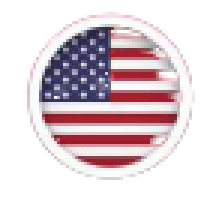

In [ ]:
a,b = set_logos('United States','Wales')
a

## `Big Table - Players`

### Function

In [ ]:
def bigTablePlayers(team=None,player=None,metric=None):
  metrics_max_values = []
  metrics_min_values = []
  big_table_players_return = pd.DataFrame()
  max_value = 0
  min_value = 0

  big_table_players = pysqldf("SELECT Equipos,rtrim(ltrim(jugador)) as 'jugador',Acciones, count(Acciones) as total FROM main_df  group by Equipos,jugador, nombre_torneo, Acciones") 
  big_table_players = big_table_players.pivot(index=['Equipos','jugador'],
                                              columns='Acciones',
                                              values='total')
  big_table_players = big_table_players.reset_index()
  big_table_players = big_table_players.fillna(0)
  big_table_players['total_centros'] = big_table_players['Centros efectivo'] + big_table_players['Centros inefectivo']
  big_table_players['efectividad_centros'] = big_table_players['Centros efectivo'] / big_table_players['total_centros']
  big_table_players['total_disputas_aereas'] = big_table_players['Disputas por arriba perdio'] + big_table_players['Disputas por arriba vencio']
  big_table_players['efectividad_disputas_aereas'] = big_table_players['Disputas por arriba vencio'] / big_table_players['total_disputas_aereas']
  big_table_players['total_disputas'] = big_table_players['Disputas perdio'] + big_table_players['Disputas vencio']
  big_table_players['efectividad_disputas'] = big_table_players['Disputas vencio'] / big_table_players['total_disputas']
  big_table_players['total_entradas'] = big_table_players['Entradas Acciones con exito'] + big_table_players['Entradas Acciones sin  exito']
  big_table_players['efectividad_entradas'] = big_table_players['Entradas Acciones con exito'] / big_table_players['total_entradas']
  big_table_players['total_pases_finalizacion'] = big_table_players['Pases de finalizacion efectivo'] + big_table_players['Pases de finalizacion inefectivo']
  big_table_players['efectividad_pases_finalizacion'] = big_table_players['Pases de finalizacion efectivo'] / big_table_players['total_pases_finalizacion']
  big_table_players['total_regates'] = big_table_players['Regates Acciones con exito'] + big_table_players['Regates Acciones sin  exito']
  big_table_players['efectividad_regates'] = big_table_players['Regates Acciones con exito'] / big_table_players['total_regates']
  big_table_players['total_pases'] = big_table_players['Pases precisos'] + big_table_players['Pases inefectivo'] + big_table_players['Asistencias']
  big_table_players['efectividad_pases'] = (big_table_players['Pases precisos'] +  big_table_players['Asistencias']) / big_table_players['total_pases']

  big_table_players['total_tiros'] = big_table_players['Tiros'] + big_table_players['Goles']
  big_table_players = big_table_players.fillna(0)


  if (team is not None and player is not None and metric is None):
    big_table_players = big_table_players.query("Equipos == @team and jugador == @player")
  elif (team is not None and player is not None and metric is not None):
    for column in metric:
      max_value = big_table_players[column].max()
      min_value = big_table_players[column].mean()
      metrics_max_values.append(max_value)
      metrics_min_values.append(min_value)

    metric.insert(0,'Equipos')
    metric.insert(1,'jugador')

    big_table_players = big_table_players[metric]
    big_table_players = big_table_players.query("Equipos == @team and jugador == @player")
  elif (team is not None and player is None and metric is None):
    big_table_players = big_table_players.query("Equipos == @team")
  elif (team is None and player is not None and metric is None):
    big_table_players = big_table_players.query("jugador == @player")
  elif (team is None and player is None and metric is not None):
    metric.insert(0,'Equipos')
    metric.insert(1,'jugador')
    
    

    

  return big_table_players, metrics_max_values, metrics_min_values

### Example

In [ ]:
player_df,max_values,min_metrics = bigTablePlayers(team='Puntarenas', player='Yoserth Hernandez Loria',metric=['Asistencias',
                                                                     'Goles',
                                                                     'efectividad_pases',
                                                                     'total_pases',
                                                                     'efectividad_regates'])
player_df,max_values,min_metrics

(Empty DataFrame
 Columns: [Equipos, jugador, Asistencias, Goles, efectividad_pases, total_pases, efectividad_regates]
 Index: [],
 [3.0, 9.0, 1.0, 674.0, 1.0],
 [0.1804733727810651,
  0.28846153846153844,
  0.8092920780218311,
  99.5103550295858,
  0.46427907792393847])

In [ ]:
bigTablePlayers(team='Saprissa')

(Empty DataFrame
 Columns: [Equipos, jugador, Asistencias, Autogol, Centros efectivo, Centros inefectivo, Conduccion, Contraataques, Corners, Disputas perdio, Disputas por arriba perdio, Disputas por arriba vencio, Disputas vencio, Entradas Acciones con exito, Entradas Acciones sin  exito, Error grave de gol, Errores de gol, Faltas, Fueras de juego, Goles, Goles encajados, Interceptaciones, Interceptaciones en campo contrario, Mal control de balon, Pases al area, Pases de finalizacion efectivo, Pases de finalizacion inefectivo, Pases inefectivo, Pases precisos, Penalti, Perdidas, Perdidas en campo contrario, Rechaces, Rechaces en campo contrario, Regates Acciones con exito, Regates Acciones sin  exito, Saque de banda a favor, Super Paradas, Tiros, Tiros en el poste / larguero, Tiros en la porteria, Tiros en la porteria parado, Tiros fuera, Tiros fuera Porteros, Tiros libres a favor, Tiros libres indirectos, total_centros, efectividad_centros, total_disputas_aereas, efectividad_disputas

## `Big Table - Teams`

### Function

In [ ]:
def bigTableTeams(team=None,metric=None):
  big_table_teams = pysqldf("SELECT Equipos,Acciones, count(Acciones) as total FROM main_df  group by Equipos, nombre_torneo, Acciones") 
  big_table_teams = big_table_teams.pivot(index=['Equipos'],
                                              columns='Acciones',
                                              values='total')
  big_table_teams = big_table_teams.reset_index()
  big_table_teams = big_table_teams.fillna(0)
  big_table_teams['total_centros'] = big_table_teams['Centros efectivo'] + big_table_teams['Centros inefectivo']
  big_table_teams['efectividad_centros'] = big_table_teams['Centros efectivo'] / big_table_teams['total_centros']
  big_table_teams['total_disputas_aereas'] = big_table_teams['Disputas por arriba perdio'] + big_table_teams['Disputas por arriba vencio']
  big_table_teams['efectividad_disputas_aereas'] = big_table_teams['Disputas por arriba vencio'] / big_table_teams['total_disputas_aereas']
  big_table_teams['total_disputas'] = big_table_teams['Disputas perdio'] + big_table_teams['Disputas vencio']
  big_table_teams['efectividad_disputas'] = big_table_teams['Disputas vencio'] / big_table_teams['total_disputas']
  big_table_teams['total_entradas'] = big_table_teams['Entradas Acciones con exito'] + big_table_teams['Entradas Acciones sin  exito']
  big_table_teams['efectividad_entradas'] = big_table_teams['Entradas Acciones con exito'] / big_table_teams['total_entradas']
  big_table_teams['total_pases_finalizacion'] = big_table_teams['Pases de finalizacion efectivo'] + big_table_teams['Pases de finalizacion inefectivo']
  big_table_teams['efectividad_pases_finalizacion'] = big_table_teams['Pases de finalizacion efectivo'] / big_table_teams['total_pases_finalizacion']
  big_table_teams['total_regates'] = big_table_teams['Regates Acciones con exito'] + big_table_teams['Regates Acciones sin  exito']
  big_table_teams['efectividad_regates'] = big_table_teams['Regates Acciones con exito'] / big_table_teams['total_regates']
  big_table_teams['total_pases'] = big_table_teams['Pases precisos'] + big_table_teams['Pases inefectivo'] + big_table_teams['Asistencias']
  big_table_teams['efectividad_pases'] = (big_table_teams['Pases precisos'] +  big_table_teams['Asistencias']) / big_table_teams['total_pases']

  big_table_teams['total_tiros'] = big_table_teams['Tiros'] + big_table_teams['Goles']
  big_table_teams['efectividad_tiros'] = (big_table_teams['Tiros en la porteria']+ big_table_teams['Goles']) / big_table_teams['total_tiros']
  big_table_teams = big_table_teams.fillna(0)


  if (team is not None and metric is None):
    big_table_teams = big_table_teams.query("Equipos == @team")
  elif (team is not None and metric is not None):
    metric.insert(0,'Equipos')
    big_table_teams = big_table_teams[metric]
    big_table_teams = big_table_teams.query("Equipos == @team")
  elif (team is None and metric is not None):
    metric.insert(0,'Equipos')
    big_table_teams = big_table_teams[metric]
    

  return big_table_teams

### Example

In [ ]:
bigTableTeams(team='Alajuelense',metric=['efectividad_tiros','Tiros en la porteria','total_tiros'])

Empty DataFrame
Columns: [Equipos, efectividad_tiros, Tiros en la porteria, total_tiros]
Index: []

In [ ]:
pysqldf("SELECT Equipos,Acciones, count(Acciones) as total FROM main_df  group by Equipos, nombre_torneo, Acciones")

Equipos                     Acciones  total
0     Argentina                  Asistencias      8
1     Argentina             Centros efectivo     16
2     Argentina           Centros inefectivo     52
3     Argentina                   Conduccion    194
4     Argentina                Contraataques    529
...         ...                          ...    ...
1352      Wales  Tiros en la porteria parado      7
1353      Wales                  Tiros fuera      7
1354      Wales         Tiros fuera Porteros     12
1355      Wales         Tiros libres a favor     56
1356      Wales      Tiros libres indirectos      1

[1357 rows x 3 columns]

## `Pass network`

### Function

In [ ]:
def pass_maps(game,team1,team2):
  import re
  import warnings
  warnings.simplefilter("ignore", UserWarning)

  # Variables
  game = game
  team1 = team1
  team2 = team2
  image_home, image_away = "",""

  game_details = main_df.query("Partido == @game")

  game_date = game_details['fecha_partido'].unique()
  home_team = game_details['equipo_casa'].unique()
  away_team = game_details['equipo_visita'].unique()
  final_result = game_details['marcador'].unique()
  tournament = game_details['nombre_torneo'].unique()

  # Clean variable strings
  game_date = str(game_date).replace('[', '').replace(']', '').replace("'",'')
  home_team = str(home_team).replace('[', '').replace(']', '').replace("'",'')
  away_team = str(away_team).replace('[', '').replace(']', '').replace("'",'')
  final_result = str(final_result).replace('[', '').replace(']', '').replace("'",'')
  tournament = str(tournament).replace('[', '').replace(']', '').replace("'",'')


  
  
  # Main graph
  pitch = VerticalPitch(pitch_type='custom',
                pitch_length=105,
                pitch_width=68,
                pitch_color='#eee9e5', 
                line_color='#01161E')
  fig, axs = pitch.grid(figheight=14 ,ncols=2, axis=False, endnote_height=0.05,title_height=0.08,)
  fig.set_facecolor("#eee9e5")
  for idx, ax in enumerate(axs['pitch'].flat):
    if idx == 0:
      ######### TEAM 1 PASS MAP #########
      ax1 = ax
      # Filter data for one game, and one team
      pass_count_players_test = pass_count_players.query("Partido == @game and Equipos == @team1 ")

      # Line colors
      MIN_TRANSPARENCY = 0.3
      color = np.array(to_rgba('#6d6a69'))
      color = np.tile(color, (len(pass_count_players_test), 1))
      c_transparency = pass_count_players_test.cantidad_pases / pass_count_players_test.cantidad_pases.max()
      c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
      color[:, 3] = c_transparency


      # Calculate Line Width
      pass_count_players_test['width']= (pass_count_players_test.cantidad_pases / pass_count_players_test.cantidad_pases.max() *
                                18)

      # Name and shirt number
      pass_count_players_test['full_name'] = pass_count_players_test.camisa + '.' + pass_count_players_test.jugador
      pass_lines = pitch.lines(pass_count_players_test['jugador_avg_pos_x'], pass_count_players_test['jugador_avg_pos_y'],
                              pass_count_players_test['jugador_end_avg_pos_x'], pass_count_players_test['jugador_end_avg_pos_y'],
                              lw=pass_count_players_test.width,
                              color=color, zorder=1, ax=ax1)
      pass_nodes = pitch.scatter(pass_count_players_test['jugador_avg_pos_x'], pass_count_players_test['jugador_avg_pos_y'],
                              s=1000, color='#eee9e5', edgecolors='#6d6a69', linewidth=1, alpha=1, ax=ax1)
      # Put player number in markers
      for index, row in pass_count_players_test.iterrows():
        pitch.annotate(row.camisa, xy=(row.jugador_avg_pos_x, row.jugador_avg_pos_y), c='#6d6a69', va='center',ha='center', size=11, ax=ax1)

      ######### TITLE SECTION #########
      #ss = pass_count_players.query("Partido == @game")
      
      #team1 = pass_count_players_test['Equipos'].unique()
      ax1.text(34, 110, team1, 
              size=35,
              fontproperties = fontprop,
              #fontname = 'Oswald',
              fontweight = 'bold',
              ha='center', va='center', color='#6d6a69')


      #################################

      # List of players
      
      players = pass_count_players_test[['full_name','camisa','jugador_avg_pos_x']]
      players = players.dropna()
      players = players.sort_values(by=['camisa'],ascending=True)
      players = players['full_name'].unique()
      players_name = str(players)
      players_name = players_name.replace('[',' ')
      players_name = players_name.replace(']',' ')
      players_name = players_name.replace("'",' ')
      
      #query = "SELECT DISTINCT full_name FROM pass_count_players_test where jugador_avg_pos_x <> 'Nan' ORDER BY 1 asc"
      #players_name =  pysqldf(query) 

      axs['endnote'].text(0, 0.5, players_name,
                      fontsize=12, va='center', ha='left', color='black')
      axs['endnote'].text(0, 1.5, 'Lineup',
                      fontsize=12, va='center', ha='left', color='black',fontweight = 'bold') 
    else:
      ######### TEAM 2 PASS MAP #########
      ax2 = ax

      # Filter data for one game, and one team
      pass_count_players_test = pass_count_players.query("Partido == @game and Equipos == @team2 ")

      # Line colors
      MIN_TRANSPARENCY = 0.3
      color = np.array(to_rgba('#6d6a69'))
      color = np.tile(color, (len(pass_count_players_test), 1))
      c_transparency = pass_count_players_test.cantidad_pases / pass_count_players_test.cantidad_pases.max()
      c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
      color[:, 3] = c_transparency



      game = pass_count_players_test['Partido'].unique()
      team = pass_count_players_test['Equipos'].unique()

      # Calculate Line Width
      pass_count_players_test['width']= (pass_count_players_test.cantidad_pases / pass_count_players_test.cantidad_pases.max() *
                                18)

      # Name and shirt number
      pass_count_players_test['full_name'] = pass_count_players_test.camisa + '.' + pass_count_players_test.jugador
      pass_lines2 = pitch.lines(pass_count_players_test['jugador_avg_pos_x'], pass_count_players_test['jugador_avg_pos_y'],
                              pass_count_players_test['jugador_end_avg_pos_x'], pass_count_players_test['jugador_end_avg_pos_y'],
                              lw=pass_count_players_test.width,
                              color=color, zorder=1, ax=ax2)
      pass_nodes2 = pitch.scatter(pass_count_players_test['jugador_avg_pos_x'], pass_count_players_test['jugador_avg_pos_y'],
                              s=1000, color='#eee9e5', edgecolors='#6d6a69', linewidth=1, alpha=1, ax=ax2)
      # Put player number in markers
      for index, row in pass_count_players_test.iterrows():
        pitch.annotate(row.camisa, xy=(row.jugador_avg_pos_x, row.jugador_avg_pos_y), c='#6d6a69', va='center',ha='center', size=11, ax=ax2)

      ######### TITLE SECTION #########
      #ss = pass_count_players.query("Partido == @game ")
      #team2 = pass_count_players_test['Equipos'].unique()
      ax2.text(34, 110,team2, 
              size=35,
              fontproperties = fontprop,
              #fontname = 'Oswald',
              fontweight = 'bold',
              ha='center', va='center', color='#6d6a69')


      #################################


      # List of players      
      players = pass_count_players_test[['full_name','camisa','jugador_avg_pos_x']]
      players = players.dropna()
      players = players.sort_values(by=['camisa'],ascending=True)
      players = players['full_name'].unique()
      players_name = str(players)
      players_name = players_name.replace('[',' ')
      players_name = players_name.replace(']',' ')
      players_name = players_name.replace("'",' ')

      axs['endnote'].text(0.55, 0.5, players_name,
                      fontsize=12, va='center', ha='left', color='black') 
      
      axs['endnote'].text(0.55, 1.5, 'Lineup',
                      fontsize=12, va='center', ha='left', color='black',fontweight = 'bold') 

      

  ######### TITLE SECTION #########
  #ss = pass_count_players.query("Partido == 'Alajuelense-0-1-Deportivo-Saprissa'")
  #team1, team2 = ss['Equipos'].unique()
  axs['title'].text(0.001, 0.88, 'Pass Networks', fontsize=20,
                     va='center', ha='left',color='#6d6a69',fontweight = 'bold',fontproperties = game_det_fontprop)
  axs['title'].text(0.001, 0.68, f'{home_team} {final_result} {away_team}', fontsize=12, 
                     va='center', ha='left',color='#6d6a69',fontproperties= title_det_fontprop)
  axs['title'].text(0.001, 0.48, f'{game_date} | {tournament}', fontsize=12,
                     va='center', ha='left',color='#6d6a69',fontproperties= title_det_fontprop)
  #################################

  ######### LOGO SECTION #########
  #logo_away = "/content/drive/MyDrive/logos/Costa Rica/Saprissa.png"
  #image_s = urlopen(logo_s)
  #image_away = Image.open(logo_away)

  #logo_home = "/content/drive/MyDrive/logos/Costa Rica/lda.png"
  #image_lda = urlopen(logo_lda)
  #image_home = Image.open(logo_home)
  
  image_home, image_away = set_logos(home_team,away_team)
  

  ax_home_logo = add_image(image_home, fig,
                        left=0.0491,
                        bottom=0.82,
                        height=0.06)

  ax_away_logo = add_image(image_away, fig, 
                                left=0.53,
                                bottom=0.82,
                                height=0.07)
  
  plt.show()

  ####################################

### Example

In [ ]:
main_df['Partido'].unique()


array(['Qatar-0-2-Ecuador', 'Senegal-0-2-Netherland', 'England-6-2-Ira',
       'United-States-1-1-Wale', 'Argentina-1-2-Saudi-Arabi',
       'Denmark-0-0-Tunisi', 'Mexico-0-0-Polan', 'Spain-7-0-Costa-Ric',
       'Germany-1-2-Japa', 'Morocco-0-0-Croati', 'France-4-1-Australia',
       'Belgium-1-0-Canad', 'Switzerland-1-0-Cameroon',
       'Uruguay-0-0-South-Kore', 'Brazil-2-0-Serbi', 'Portugal-3-2-Ghan',
       'Wales-0-2-Ira', 'Japan-0-1-Costa-Ric', 'Argentina-2-0-Mexic',
       'France-2-1-Denmark', 'Poland-2-0-Saudi-Arabia',
       'Tunisia-0-1-Australi', 'England-0-0-United-State',
       'Netherlands-1-1-Ecuador', 'Qatar-1-3-Senegal',
       'Belgium-0-2-Morocco', 'Croatia-4-1-Canad', 'Spain-1-1-Germany',
       'Cameroon-3-3-Serbia', 'South-Korea-2-3-Ghana',
       'Portugal-2-0-Uruguay', 'Brazil-1-0-Switzerlan',
       'Netherlands-2-0-Qata', 'Ecuador-1-2-Senegal',
       'Iran-0-1-United-States', 'Wales-0-3-Englan',
       'Australia-1-0-Denmar', 'Tunisia-1-0-France',
       

<ipython-input-28-44b645b75636>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_count_players_test['width']= (pass_count_players_test.cantidad_pases / pass_count_players_test.cantidad_pases.max() *
<ipython-input-28-44b645b75636>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_count_players_test['full_name'] = pass_count_players_test.camisa + '.' + pass_count_players_test.jugador
<ipython-input-28-44b645b75636>:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

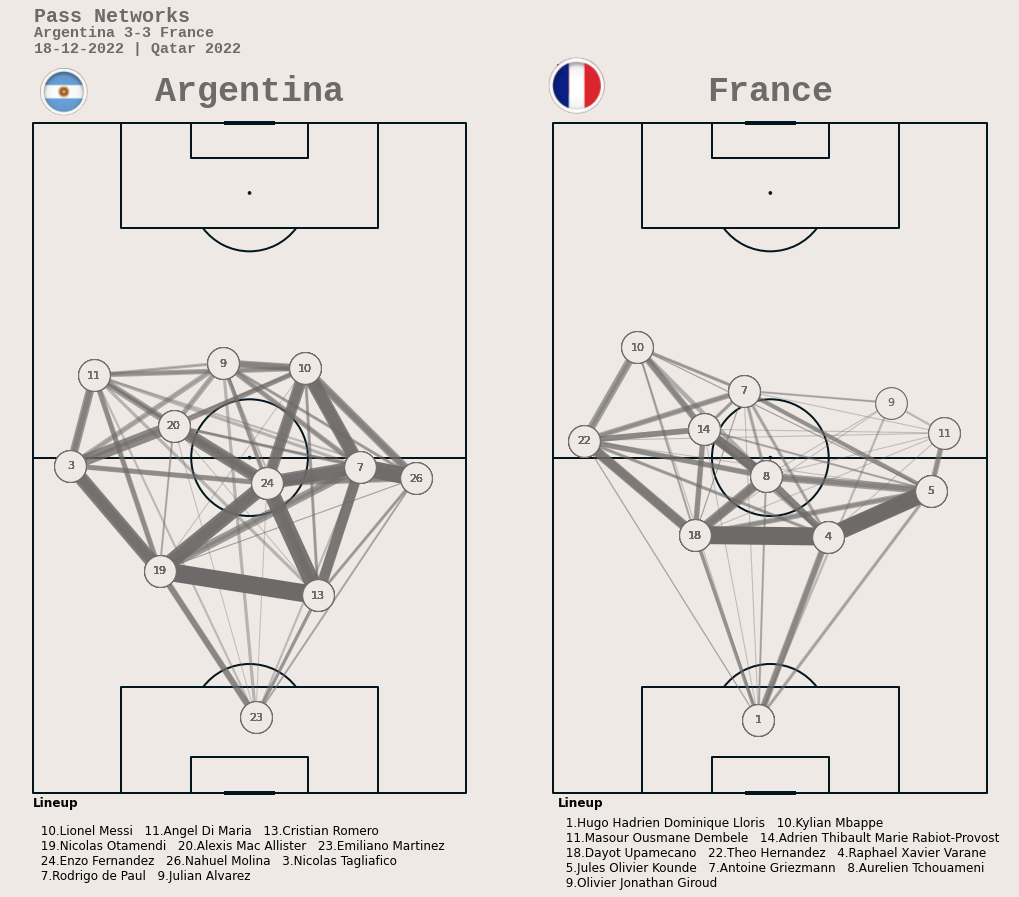

In [ ]:
pass_maps('Argentina-3-3-France','Argentina','France')


In [ ]:
main_df['Partido'].unique()

array(['Qatar-0-2-Ecuador', 'Senegal-0-2-Netherland', 'England-6-2-Ira',
       'United-States-1-1-Wale', 'Argentina-1-2-Saudi-Arabi',
       'Denmark-0-0-Tunisi', 'Mexico-0-0-Polan', 'Spain-7-0-Costa-Ric',
       'Germany-1-2-Japa', 'Morocco-0-0-Croati', 'France-4-1-Australia',
       'Belgium-1-0-Canad', 'Switzerland-1-0-Cameroon',
       'Uruguay-0-0-South-Kore', 'Brazil-2-0-Serbi', 'Portugal-3-2-Ghan',
       'Wales-0-2-Ira', 'Japan-0-1-Costa-Ric', 'Argentina-2-0-Mexic',
       'France-2-1-Denmark', 'Poland-2-0-Saudi-Arabia',
       'Tunisia-0-1-Australi', 'England-0-0-United-State',
       'Netherlands-1-1-Ecuador', 'Qatar-1-3-Senegal',
       'Belgium-0-2-Morocco', 'Croatia-4-1-Canad', 'Spain-1-1-Germany',
       'Cameroon-3-3-Serbia', 'South-Korea-2-3-Ghana',
       'Portugal-2-0-Uruguay', 'Brazil-1-0-Switzerlan',
       'Netherlands-2-0-Qata', 'Ecuador-1-2-Senegal',
       'Iran-0-1-United-States', 'Wales-0-3-Englan',
       'Australia-1-0-Denmar', 'Tunisia-1-0-France',
       

In [ ]:
fm.findSystemFonts(fontpaths=None, fontext="ttf")
#!rm ~/.cache/matplotlib -rf

['/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-BoldItalic.ttf',
 '/usr/share/fonts/truetype/humor-sans/Humor-Sans.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSans-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSerif-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Italic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf',
 '/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf',
 '/usr/share/fonts/truetype/liberation

## `Team heatmap`

### Function

In [ ]:
def team_heatmap(data,game,team):
  from matplotlib.colors import LinearSegmentedColormap

  game = game
  team = team

  # Filter data for the specific game and team
  data_df = data.query("Partido == @game and Equipos == @team ")

  # Convert columns to numeric
  data_df['pos_x'] = pd.to_numeric(data_df['pos_x'])
  data_df['pos_y'] = pd.to_numeric(data_df['pos_y'])
  
  # Setup the rival team
  rival = data_df.query("rival != @team")
  rival = rival['rival'].unique()


  # Main
  pitch = VerticalPitch(pitch_type='custom',
                pitch_length=105,
                pitch_width=68,
                pitch_color='#eee9e5',
                line_zorder=2, 
                line_color='#01161E')
  fig, ax = pitch.draw(figsize=(8, 14))
  fig.set_facecolor("#eee9e5")

  pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#eee9e5', '#2f3e46'], N=100)
  
  kdeplot = pitch.kdeplot(data_df.pos_x, data_df.pos_y, ax=ax, cmap=pearl_earring_cmap, shade=True, levels=300)
  #ax.set_title(f'Jean Carlos Sanchez', fontsize=30, pad=-20)
  #subtitle = "{} \n vs {}".format(team,rival)
  #ax.set_title(subtitle, fontsize=30, pad=-20)

  _,image_team = set_logos(team,team)

  ax_logo = add_image(image_team, fig,
                        left=0.0480,
                        bottom=0.88,
                        height=0.05)
  ax.text(34, 110,team, 
              size=35,
              fontproperties = fontprop,
              #fontname = 'Oswald',
              fontweight = 'bold',
              ha='center', va='center', color='#6d6a69')


### Example

<ipython-input-33-92ea0ff9a1f4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['pos_x'] = pd.to_numeric(data_df['pos_x'])
<ipython-input-33-92ea0ff9a1f4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['pos_y'] = pd.to_numeric(data_df['pos_y'])


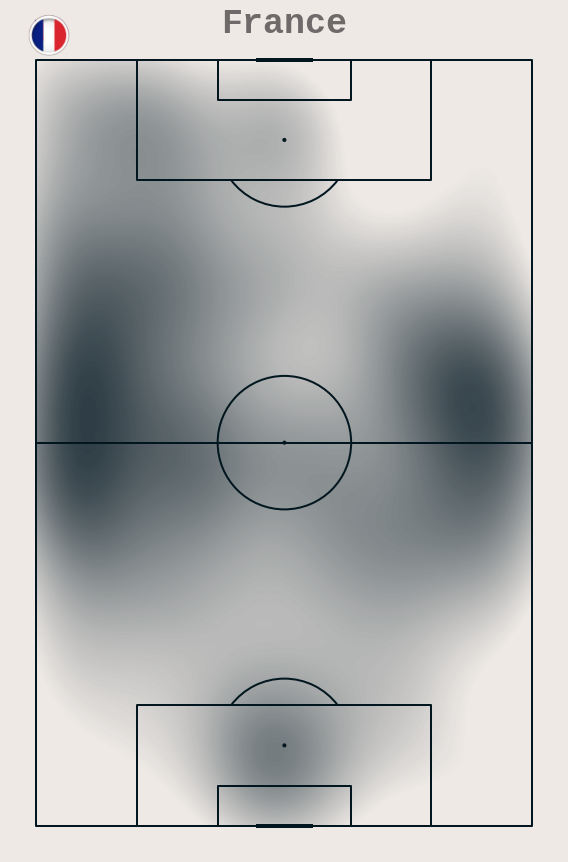

In [ ]:
a = team_heatmap(main_df,game='Argentina-3-3-France',team='France')


## `Average Positions`

### Function

In [ ]:
def players_pos(game):
  game = game

  main_df['pos_x'] = pd.to_numeric(main_df['pos_x'])
  main_df['pos_y'] = pd.to_numeric(main_df['pos_y'])


  #https://sql2pandas.pythonanywhere.com/cookbook/sql-avg-in-pandas
  data_pos = main_df.groupby(['Partido','Equipos','camisa','jugador']).agg(avg_pos_x=('pos_x', 'mean'), avg_pos_y=('pos_y', 'mean')).reset_index() 
  data_pos = data_pos.query("Partido == @game ")

  
  return data_pos


In [ ]:
def average_positions(game,team1,team2):

  warnings.simplefilter("ignore", UserWarning)

  # Variables
  game = game
  team1 = team1
  team2 = team2

  # Get starting 11
  start11 = get_lineups(main_df)

  # Get average position for players in the game
  avg_position = players_pos(game)

  # Join starting 11 and avg positions to get the satring 11 players with the corresponding average position for the game
  avg_position = avg_position.join(start11.set_index(['Partido','Equipos','camisa','jugador']), on=['Partido','Equipos','camisa','jugador'],lsuffix="_avg",rsuffix='_str')
  avg_position = avg_position.query("Partido == @game")
  avg_position = avg_position.dropna()

  avg_position['full_name'] = avg_position.camisa + '.' + avg_position.jugador

    
  
  # Get game details for title
  game_details = main_df.query("Partido == @game")

  game_date = game_details['fecha_partido'].unique()
  home_team = game_details['equipo_casa'].unique()
  away_team = game_details['equipo_visita'].unique()
  final_result = game_details['marcador'].unique()
  tournament = game_details['nombre_torneo'].unique()

  # Clean variable strings
  game_date = str(game_date).replace('[', '').replace(']', '').replace("'",'')
  home_team = str(home_team).replace('[', '').replace(']', '').replace("'",'')
  away_team = str(away_team).replace('[', '').replace(']', '').replace("'",'')
  final_result = str(final_result).replace('[', '').replace(']', '').replace("'",'')
  tournament = str(tournament).replace('[', '').replace(']', '').replace("'",'')


  
  
  # Main graph
  pitch = VerticalPitch(pitch_type='custom',
                pitch_length=105,
                pitch_width=68,
                pitch_color='#eee9e5', 
                line_color='#01161E')
  fig, axs = pitch.grid(figheight=14 ,ncols=2, axis=False, endnote_height=0.05,title_height=0.08,)
  fig.set_facecolor("#eee9e5")
  for idx, ax in enumerate(axs['pitch'].flat):
    if idx == 0:
      ######### TEAM 1 PASS MAP #########
      ax1 = ax
      # Filter data for one game, and one team
      team1_posiciones = avg_position.query("Equipos == @team1 ")

      hull = pitch.convexhull(team1_posiciones.avg_pos_x, team1_posiciones.avg_pos_y)
      poly = pitch.polygon(hull, ax=ax1, edgecolor='#6d6a69', facecolor='#6d6a69', alpha=0.3)

      pass_nodes = pitch.scatter(team1_posiciones['avg_pos_x'], team1_posiciones['avg_pos_y'],
                              s=1000, color='#6d6a69', edgecolors='black', linewidth=1, alpha=1, ax=ax1)

      # Put player number in markers
      for index, row in team1_posiciones.iterrows():
        pitch.annotate(row.camisa, xy=(row.avg_pos_x, row.avg_pos_y), c='white', va='center',ha='center',fontweight = 'bold', size=11, ax=ax1)

      ######### TITLE SECTION #########
      #ss = pass_count_players.query("Partido == @game")
      
      #team1 = pass_count_players_test['Equipos'].unique()
      ax1.text(34, 110, team1, 
              size=35,
              fontproperties = fontprop,
              #fontname = 'Oswald',
              fontweight = 'bold',
              ha='center', va='center', color='#6d6a69')


      #################################

      # List of players
      
      players = team1_posiciones[['full_name','camisa']]
      players = players.dropna()
      players = players.sort_values(by=['camisa'],ascending=True)
      players = players['full_name'].unique()
      players_name = str(players)
      players_name = players_name.replace('[',' ')
      players_name = players_name.replace(']',' ')
      players_name = players_name.replace("'",' ')
      


      axs['endnote'].text(0, 0.5, players_name,
                      fontsize=12, va='center', ha='left', color='black')
      axs['endnote'].text(0, 1.5, 'Lineup',
                      fontsize=12, va='center', ha='left', color='black',fontweight = 'bold') 
    else:
      
      ######### TEAM 2 PASS MAP #########
      ax2 = ax

      # Filter data for one game, and one team
      team2_posiciones = avg_position.query("Equipos == @team2 ")

      team = team2

      hull = pitch.convexhull(team2_posiciones.avg_pos_x, team2_posiciones.avg_pos_y)
      poly = pitch.polygon(hull, ax=ax2, edgecolor='#6d6a69', facecolor='#6d6a69', alpha=0.3)

      pass_nodes2 = pitch.scatter(team2_posiciones['avg_pos_x'], team2_posiciones['avg_pos_y'],
                              s=1000, color='#6d6a69', edgecolors='black', linewidth=1, alpha=1, ax=ax2)
      # Put player number in markers
      for index, row in team2_posiciones.iterrows():
        pitch.annotate(row.camisa, xy=(row.avg_pos_x, row.avg_pos_y), c='white', va='center',ha='center',fontweight = 'bold', size=11, ax=ax2)

      ######### TITLE SECTION #########
      ax2.text(34, 110,team2, 
              size=35,
              fontproperties = fontprop,
              #fontname = 'Oswald',
              fontweight = 'bold',
              ha='center', va='center', color='#6d6a69')


      #################################


      # List of players      
      players = team2_posiciones[['full_name','camisa']]
      players = players.dropna()
      players = players.sort_values(by=['camisa'],ascending=True)
      players = players['full_name'].unique()
      players_name = str(players)
      players_name = players_name.replace('[',' ')
      players_name = players_name.replace(']',' ')
      players_name = players_name.replace("'",' ')

      axs['endnote'].text(0.55, 0.5, players_name,
                      fontsize=12, va='center', ha='left', color='black') 
      
      axs['endnote'].text(0.55, 1.5, 'Lineup',
                      fontsize=12, va='center', ha='left', color='black',fontweight = 'bold') 
      
      

  ######### TITLE SECTION #########
  axs['title'].text(0.001, 0.88, 'Average Position', fontsize=20,
                     va='center', ha='left',color='#6d6a69',fontweight = 'bold',fontproperties = game_det_fontprop)
  axs['title'].text(0.001, 0.68, f'{home_team} {final_result} {away_team}', fontsize=12, 
                     va='center', ha='left',color='#6d6a69',fontproperties= title_det_fontprop)
  axs['title'].text(0.001, 0.48, f'{game_date} | {tournament}', fontsize=12,
                     va='center', ha='left',color='#6d6a69',fontproperties= title_det_fontprop)
  #################################

  ######### LOGO SECTION #########
  image_home, image_away = set_logos(team1,team2)

  ax_home_logo = add_image(image_home, fig,
                        left=0.0491,
                        bottom=0.82,
                        height=0.06)

  ax_away_logo = add_image(image_away, fig, 
                                left=0.53,
                                bottom=0.82,
                                height=0.07)
  
  plt.show()

  ####################################

### Example

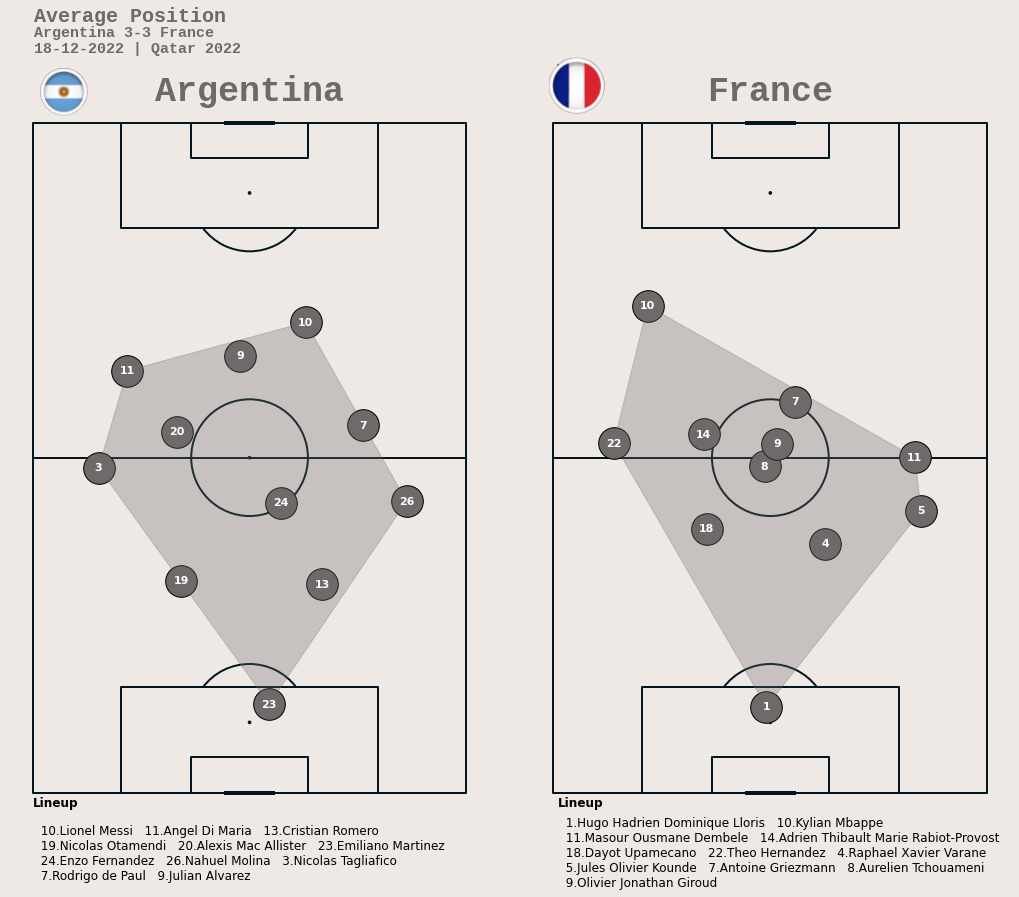

In [ ]:
average_positions('Argentina-3-3-France','Argentina','France')

In [ ]:
main_df['Partido'].unique()

array(['Qatar-0-2-Ecuador', 'Senegal-0-2-Netherland', 'England-6-2-Ira',
       'United-States-1-1-Wale', 'Argentina-1-2-Saudi-Arabi',
       'Denmark-0-0-Tunisi', 'Mexico-0-0-Polan', 'Spain-7-0-Costa-Ric',
       'Germany-1-2-Japa', 'Morocco-0-0-Croati', 'France-4-1-Australia',
       'Belgium-1-0-Canad', 'Switzerland-1-0-Cameroon',
       'Uruguay-0-0-South-Kore', 'Brazil-2-0-Serbi', 'Portugal-3-2-Ghan',
       'Wales-0-2-Ira', 'Japan-0-1-Costa-Ric', 'Argentina-2-0-Mexic',
       'France-2-1-Denmark', 'Poland-2-0-Saudi-Arabia',
       'Tunisia-0-1-Australi', 'England-0-0-United-State',
       'Netherlands-1-1-Ecuador', 'Qatar-1-3-Senegal',
       'Belgium-0-2-Morocco', 'Croatia-4-1-Canad', 'Spain-1-1-Germany',
       'Cameroon-3-3-Serbia', 'South-Korea-2-3-Ghana',
       'Portugal-2-0-Uruguay', 'Brazil-1-0-Switzerlan',
       'Netherlands-2-0-Qata', 'Ecuador-1-2-Senegal',
       'Iran-0-1-United-States', 'Wales-0-3-Englan',
       'Australia-1-0-Denmar', 'Tunisia-1-0-France',
       

In [ ]:
'''
cambios_df = main_df.query("Partido == 'Alajuelense-1-1-Sporting-FC2' and Equipos == 'Alajuelense' ")
cambios_df['ID'] = pd.to_numeric(cambios_df['ID'])
ultimas_acciones_jugadores = pysqldf("Select MAX([ID]) ultima_accion, jugador FROM cambios_df GROUP BY jugador ")
primeras_acciones_jugadores = pysqldf("Select MIN([ID]) primera_accion, jugador FROM cambios_df GROUP BY jugador ")
ultimas_acciones_jugadores

titulares = get_lineups(main_df)

titulares = titulares.query("Partido == 'Alajuelense-1-1-Sporting-FC2' and Equipos == 'Alajuelense'")
titulares

estado_titularidad = pysqldf("SELECT A.*, B.jugador as 'titular' FROM cambios_df A LEFT JOIN titulares B ON A.Partido = B.Partido and A.Equipos = B.Equipos and A.jugador = B.jugador")
estado_titularidad2 = pysqldf("SELECT DISTINCT jugador, titular FROM estado_titularidad")

pysqldf("SELECT A.*, B.*, C.* FROM estado_titularidad2 A LEFT JOIN ultimas_acciones_jugadores B ON A.jugador = B.jugador LEFT JOIN primeras_acciones_jugadores C ON A.jugador = C.jugador")
'''

'\ncambios_df = main_df.query("Partido == \'Alajuelense-1-1-Sporting-FC2\' and Equipos == \'Alajuelense\' ")\ncambios_df[\'ID\'] = pd.to_numeric(cambios_df[\'ID\'])\nultimas_acciones_jugadores = pysqldf("Select MAX([ID]) ultima_accion, jugador FROM cambios_df GROUP BY jugador ")\nprimeras_acciones_jugadores = pysqldf("Select MIN([ID]) primera_accion, jugador FROM cambios_df GROUP BY jugador ")\nultimas_acciones_jugadores\n\ntitulares = get_lineups(main_df)\n\ntitulares = titulares.query("Partido == \'Alajuelense-1-1-Sporting-FC2\' and Equipos == \'Alajuelense\'")\ntitulares\n\nestado_titularidad = pysqldf("SELECT A.*, B.jugador as \'titular\' FROM cambios_df A LEFT JOIN titulares B ON A.Partido = B.Partido and A.Equipos = B.Equipos and A.jugador = B.jugador")\nestado_titularidad2 = pysqldf("SELECT DISTINCT jugador, titular FROM estado_titularidad")\n\npysqldf("SELECT A.*, B.*, C.* FROM estado_titularidad2 A LEFT JOIN ultimas_acciones_jugadores B ON A.jugador = B.jugador LEFT JOIN prime

## Testing

In [ ]:
main_df['equipo_visita'].unique()

array(['Ecuador', 'Netherlands', 'Iran', 'Wales', 'Saudi Arabia',
       'Tunisia', 'Poland', 'Costa Rica', 'Japan', 'Croatia', 'Australia',
       'Canada', 'Cameroon', 'South Korea', 'Serbia', 'Ghana', 'Mexico',
       'Denmark', 'United States', 'Senegal', 'Morocco', 'Germany',
       'Uruguay', 'Switzerlan', 'Qatar', 'United-States', 'England',
       'France', 'Argentina', 'Belgium', 'Spain', 'Brazil', 'Portugal',
       'Switzerland'], dtype=object)

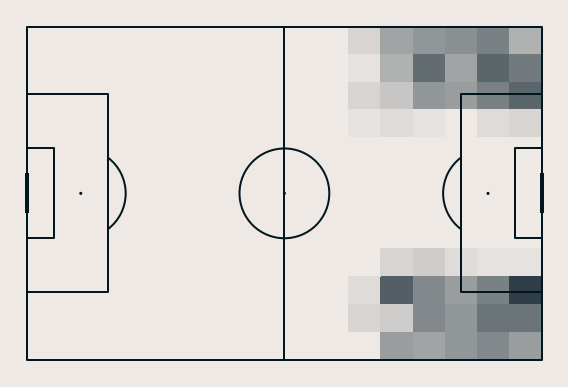

In [ ]:
centros_df = main_df.query("Acciones == 'Centros efectivo'")
pitch = Pitch(pitch_type='custom',
                  pitch_length=105,
                  pitch_width=68,
                  line_zorder=2, 
                  line_color='#01161E',
                  pitch_color='None')
fig, ax = pitch.draw(figsize=(8, 14))
fig.set_facecolor("#eee9e5")
bins = (16, 12)
x = pd.to_numeric(centros_df['pos_x'])
y = pd.to_numeric(centros_df['pos_y'])
stats = pitch.bin_statistic(x, y,bins=bins)
pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                      ['#eee9e5', '#2f3e46'], N=100)
pitch.heatmap(stats, cmap=pearl_earring_cmap, ax=ax)

In [ ]:
radar_df,max_values,min_values = bigTablePlayers(team='Saprissa', player='Ryan Bolanos Davis',metric=['efectividad_centros',
                                                                     'efectividad_entradas',
                                                                     'efectividad_disputas_aereas',
                                                                     'efectividad_pases',
                                                                     'total_pases',
                                                                     'efectividad_regates',
                                                                     'Rechaces',
                                                                     'Interceptaciones'])

metrics_text = radar_df.columns
metrics_text = list(metrics_text)
metrics_values = []
for column in metrics_text:
  metrics_values.append(radar_df[column].values)
  
metrics_values = np.array(metrics_values)
metrics_values = metrics_values.flatten('F')
metrics_values = list(metrics_values)
metrics_values


[]

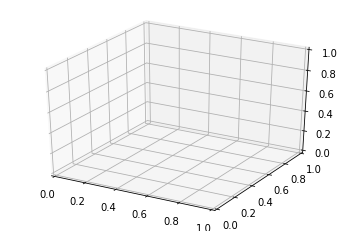

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection='3d')

##`Control Zones`

'\n# Detalle del texto de metricas de pases\nannotation_string = (f\'Controled Zones\' |\n                     f\'\n Sion vs Luzern\')\n\n# Configuracion para el highlight de los textos de metricas\nhighlight_textprops = [{"fontsize":25, "color":\'#2f3e46\',"fontweight":\'bold\'},\n                      {"fontsize":15, "color":\'#FB4D3D\',"fontweight":\'bold\'}]\n\n# Ubicacion del texto con detalle de metricas\nax_text(8, 70, annotation_string, ha=\'left\', va=\'center\', fontsize=15,\n        highlight_textprops=highlight_textprops,\n              #fontproperties=fm_scada.prop,  # using the fontmanager for the google font\n              ax=ax)\n'

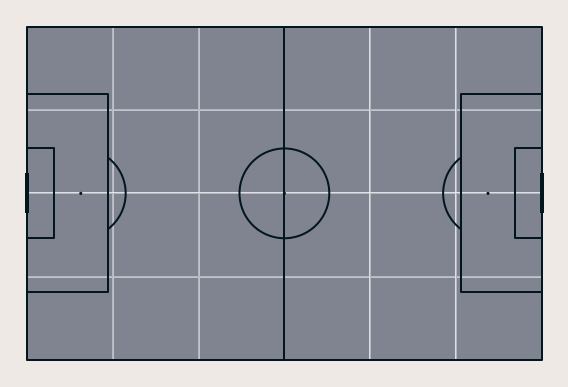

In [ ]:
game_df = pass_flow_df.query("Partido == 'Lugano-2-0-Zurich2' ")
home_team_passes = game_df.query("Equipos == 'Lugano' ")
away_team_passes = game_df.query("Equipos == 'Zurich' ")

from mplsoccer import Pitch
import numpy as np
from matplotlib import colors


pitch = Pitch(pitch_type='custom',
                  pitch_length=105,
                  pitch_width=68,
                  line_zorder=2, 
                  line_color='#01161E',
                  pitch_color='None')
fig, ax = pitch.draw(figsize=(8, 14))
fig.set_facecolor("#eee9e5")



bins = (6, 4)
x = pd.to_numeric(game_df['pos_x'])
y = pd.to_numeric(game_df['pos_y'])

#-- Home
home_x = pd.to_numeric(home_team_passes['pos_x'])
home_y = pd.to_numeric(home_team_passes['pos_y'])
home_stats = pitch.bin_statistic(home_x, home_y,bins=bins)

#-- away
away_x = pd.to_numeric(away_team_passes['pos_x'])
away_y = pd.to_numeric(away_team_passes['pos_y'])
away_x_inv = 0 + (105-away_x)
away_y_inv = 0 + (68 - away_y)
away_stats = pitch.bin_statistic(away_x_inv, away_y_inv,bins=bins)



for j in range(len(home_stats['statistic'])):
        for k in range(len(home_stats['statistic'][j])):
            total_touches = home_stats['statistic'][j][k] + away_stats['statistic'][j][k]
            #print('home passes:',home_stats['statistic'][j][k])
            #print('away passes:',away_stats['statistic'][j][k])
            # print('total passes',total_touches)
            # print('55% of total passes', (total_touches * 0.55))
            # print('45% of total passes', (total_touches * 0.455))
            if home_stats['statistic'][j][k] < (total_touches * 0.55) and home_stats['statistic'][j][k] > (total_touches * 0.45):
                home_stats['statistic'][j][k] = 100
            elif home_stats['statistic'][j][k] > away_stats['statistic'][j][k]:
                home_stats['statistic'][j][k] = 50
            else:
                home_stats['statistic'][j][k] = 0

    #plot the heatmap     
#cmap = colors.ListedColormap(['#CCCCCC','#9656A2','#B02C3F'])  # (away,home,contest)
cmap = colors.ListedColormap(['#14213d','#eee9e5','#fca311'])  #(azul,naranja,blanco) 
hm = pitch.heatmap(home_stats, ax=ax, cmap=cmap, edgecolors = '#ffffff',alpha=0.5)

'''
# Detalle del texto de metricas de pases
annotation_string = (f'Controled Zones' |
                     f'\n Sion vs Luzern')

# Configuracion para el highlight de los textos de metricas
highlight_textprops = [{"fontsize":25, "color":'#2f3e46',"fontweight":'bold'},
                      {"fontsize":15, "color":'#FB4D3D',"fontweight":'bold'}]

# Ubicacion del texto con detalle de metricas
ax_text(8, 70, annotation_string, ha='left', va='center', fontsize=15,
        highlight_textprops=highlight_textprops,
              #fontproperties=fm_scada.prop,  # using the fontmanager for the google font
              ax=ax)
'''

## `Pass Cluster`

### Cluster function

In [ ]:
def team_clusters(clusters,pass_data=pass_flow_df,team=None, game=None,player=None):

  from sklearn.cluster import KMeans
  team = team
  game = game
  player = player

  # Load team's pass data
  if team != None and game == None:
    team_1_passes = pass_data.query("Equipos == @team ")
  elif team !=None and game != None:
    team_1_passes = pass_data.query("Equipos == @team and Partido == @game ")
  elif team ==None and game == None and player != None:
    team_1_passes = pass_data.query("jugador == @player ")

  # New pass dataframe
  pass_team_1 = pd.DataFrame()
  pass_team_1['start_x'] = team_1_passes.pos_x
  pass_team_1['start_y'] = team_1_passes.pos_y
  pass_team_1['end_x'] = team_1_passes.pos_x_end
  pass_team_1['end_y'] = team_1_passes.pos_y_end
  pass_team_1['player'] = team_1_passes.jugador
  pass_team_1['recipient'] = team_1_passes.jugador_end
  pass_team_1['pass_distance'] = np.sqrt(np.square(pass_team_1['end_x'].astype(float) - pass_team_1['start_x'].astype(float)) + np.square(pass_team_1['end_y'].astype(float) - pass_team_1['start_y'].astype(float)) ) 

  # Cluster definition
  N_clusters = clusters
  X_1 = np.array(pass_team_1[['start_x', 'start_y', 'end_x', 'end_y']])

  kmeans = KMeans(n_clusters = N_clusters, random_state = 0).fit(X_1)
  cluster_labels = kmeans.predict(X_1)
  pass_team_1['n_cluster'] = cluster_labels
  centroids_1 = pd.DataFrame(data = kmeans.cluster_centers_, columns = ['start_x', 'start_y', 'end_x', 'end_y'])

  return pass_team_1, centroids_1

In [ ]:
team_clusters(clusters=10, team='Argentina', game=None, player=None)

(       start_x start_y end_x end_y                 player  \
 8083      34.2    66.8  43.6  64.4     Nicolas Tagliafico   
 8084      43.6    64.4  34.8  59.9       Lautaro Martinez   
 8085      34.8    59.9  17.2  54.6        Leandro Paredes   
 8086      17.2    54.6  22.2  23.6       Nicolas Otamendi   
 8087      22.2    23.6  35.6  23.4        Cristian Romero   
 ...        ...     ...   ...   ...                    ...   
 132919    38.2    24.4  41.9  22.6           Paulo Dybala   
 132920    41.9    22.6  50.4  16.1         Enzo Fernandez   
 132922    59.4    15.4  91.1  17.7           Lionel Messi   
 132924    96.8    17.1  92.1  34.9  Gonzalo Ariel Montiel   
 132936    39.8    49.2  50.3  51.7        Leandro Paredes   
 
                     recipient  pass_distance  n_cluster  
 8083         Lautaro Martinez       9.701546          9  
 8084          Leandro Paredes       9.883825          9  
 8085         Nicolas Otamendi      18.380696          1  
 8086          Cri

In [ ]:
main_df['jugador'].unique()

## `Cluster visualization`

### Function

In [ ]:
def team_cluster_visualization(team,game,player, n_clusters,n_rows,n_cols):
  from mplsoccer.pitch import Pitch
  #from mplsoccer.statsbomb import read_event, EVENT_SLUG
  from matplotlib import rcParams

  # Cluster data
  team_pass_df, team_centroids = team_clusters(clusters=n_clusters, team=team,game=game, player=player)

  # Colors for clusters
  cluster_colors = ['#264653','#2a9d8f','#e9c46a','#f4a261','#e76f51',
                    '#ca5310','#a3b18a','#588157','#3a5a40','#344e41',
                    '#22223b','#4a4e69','#c9ada7','#9a8c98','#C3423F',
                    '#fbba72','#ca5310','#bb4d00','#8f250c','#691e06']

  # Viz configuration
  pitch = Pitch(pitch_type='custom',
                  axis=False,
                  pitch_length=105,
                  pitch_width=68,
                  line_zorder=2,
                  pitch_color='#eee9e5',
                  line_color='#01161E')
  #bins = (6, 4)
  # plot the 5 * 3 grid
  fig, axs = pitch.grid(nrows=n_rows, ncols=n_cols, figheight=30,
                        endnote_height=0.03, endnote_space=0,
                        axis=False,
                        title_height=0.10, grid_height=0.84)
  fig.set_facecolor('#eee9e5')

  for idx, ax in enumerate(axs['pitch'].flat):
    if idx < len(team_centroids):

      tmp_team_pass_df = team_pass_df.query("n_cluster==@idx")
      tmp_team_centroids = team_centroids.iloc[idx]
      n_passes = len(tmp_team_pass_df)
      pct_passes = n_passes / len(team_pass_df)
      distance_avg = round(tmp_team_pass_df["pass_distance"].mean(),1)

      passes = pitch.arrows(tmp_team_pass_df['start_x'].astype(float),  tmp_team_pass_df['start_y'].astype(float),
                  tmp_team_pass_df['end_x'].astype(float), tmp_team_pass_df['end_y'].astype(float),
                  width=3, label='all passes',alpha=0.1,
                  color=cluster_colors[idx], ax=ax)

      clusters = pitch.arrows(tmp_team_centroids['start_x'], tmp_team_centroids['start_y'],
                  tmp_team_centroids['end_x'], tmp_team_centroids['end_y'],
                  width=9,label='cluster',
                  facecolor=cluster_colors[idx], edgecolor='#000000',linewidth = 4, ax=ax)


      #print(teams[idx])
      #team = teams[idx]

      # Detalle del texto de metricas de pases
      annotation_string = (f'Cluster #<{int(idx)}> | '
                        f'passes:<{n_passes}> ({round(pct_passes*100,1)})% | '
                        f'avg distance:<{distance_avg}> mts')
                        #f'Efectividad:<{int((efectividad_centros*100))}%>')
  
      # Configuracion para el highlight de los textos de metricas
      highlight_textprops = [{"fontsize":40, "color":'#000000',"fontweight":'bold'},
                          {"fontsize":40, "color":'#000000',"fontweight":'bold'},
                          {"fontsize":40, "color":'#000000',"fontweight":'bold'}]

      #text = f'Cluster #{idx} | passes: {n_passes} | avg distance: {distance_avg} mts'
      ax_text(0, 72, annotation_string , ha='left', va='center',highlight_textprops=highlight_textprops, fontsize=40,ax=ax)


      ######### TITLE SECTION #########
      #ss = pass_count_players.query("Partido == 'Alajuelense-0-1-Deportivo-Saprissa'")
      #team1, team2 = ss['Equipos'].unique()
      axs['title'].text(0.001, 1.8, f'Pass Clustering | {team}', fontsize=95,
                        va='center', ha='left',color='#6d6a69',fontweight = 'bold')
      axs['title'].text(0.001, 1.3, 'Grouping passes that are substantially identical', fontsize=60, 
                        va='center', ha='left',color='#6d6a69')
      axs['title'].text(0.001, 0.10, '.', fontsize=100,
                        va='center', ha='left',color='#6d6a69')
      #################################

      image_home, _ = set_logos(team,team)
      ax_home_logo = add_image(image_home, fig,
                      left=0.90,
                      bottom=0.92,
                      height=0.2)
      
      


### Example

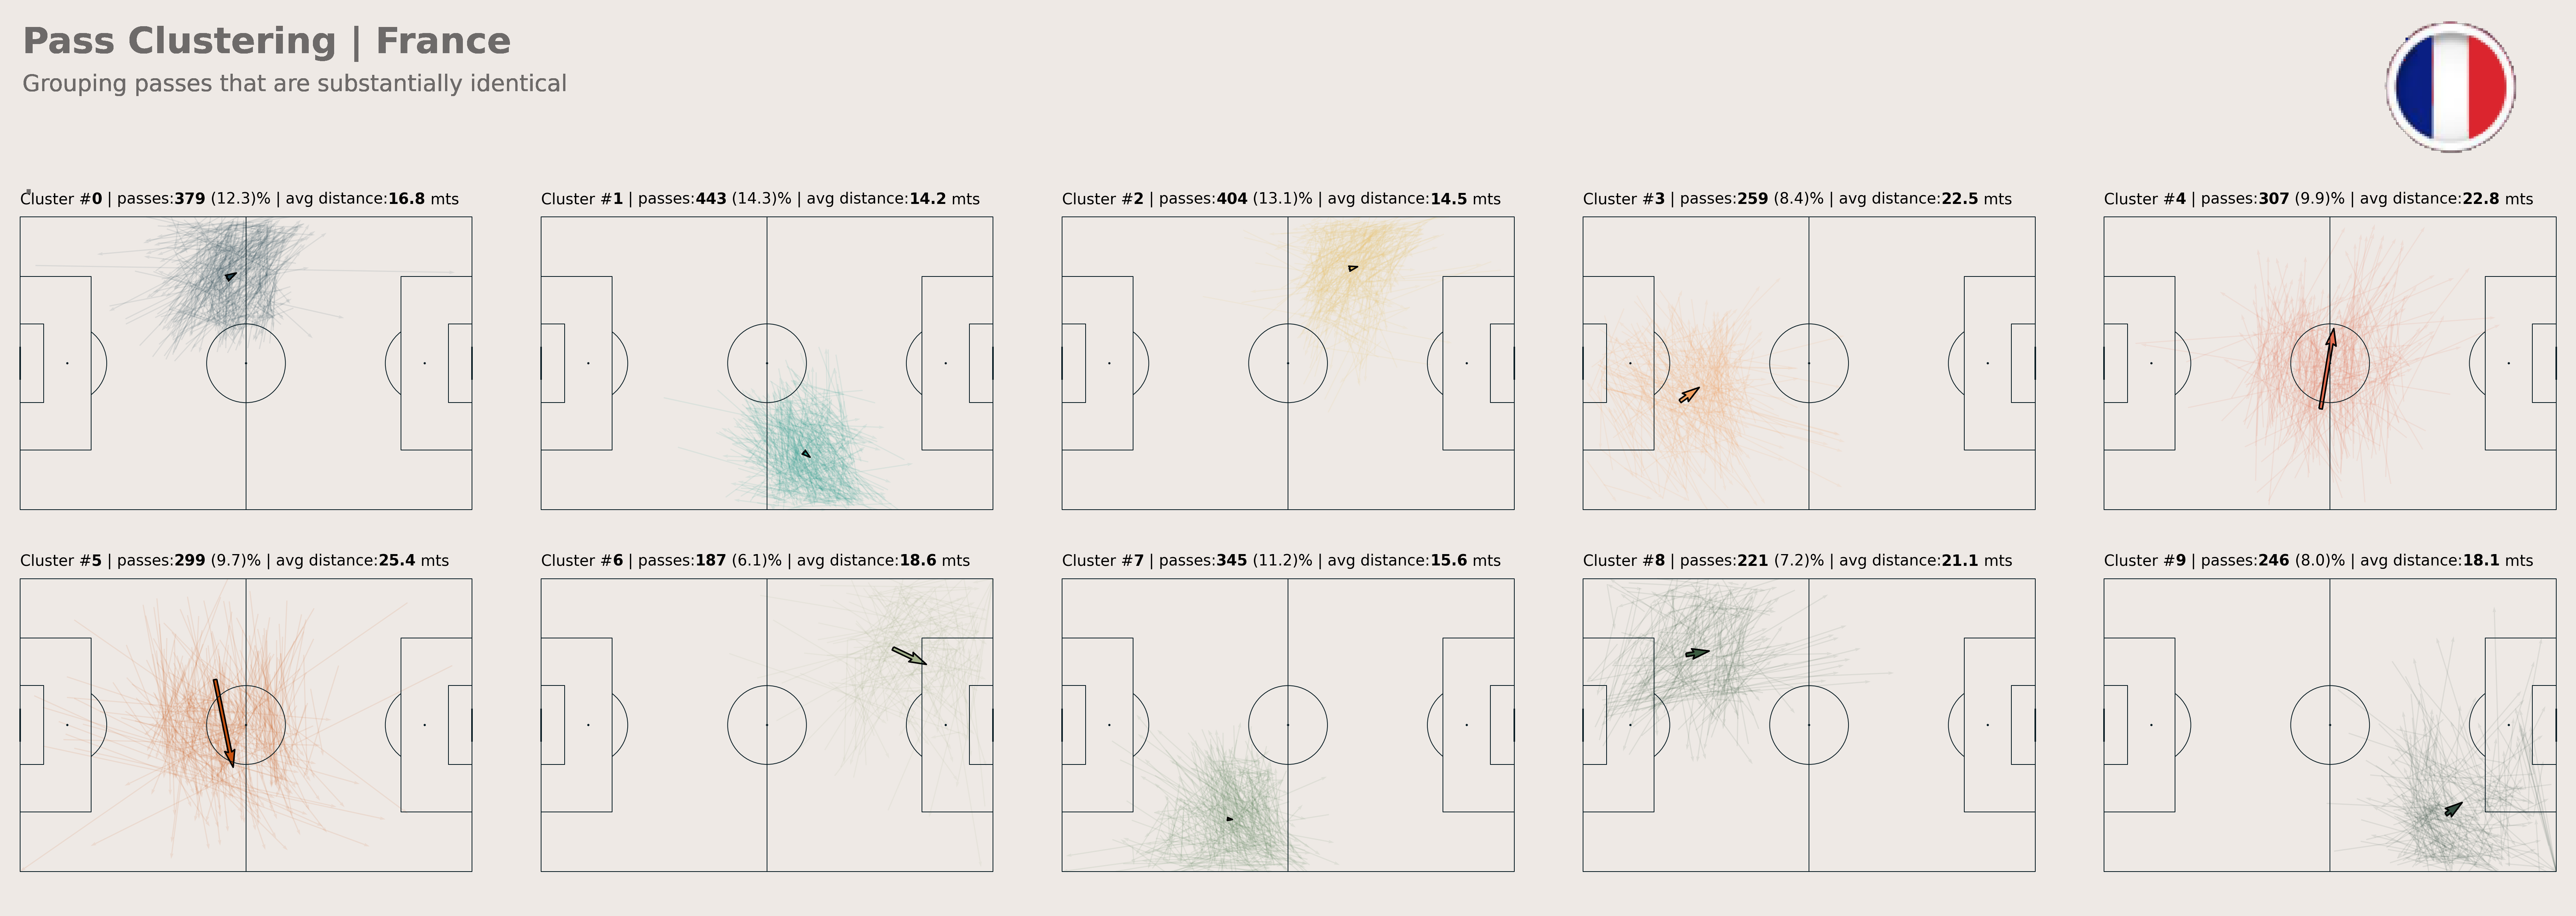

In [ ]:
team_cluster_visualization(team='France',game=None,player=None, n_clusters=10,n_rows=2,n_cols=5)

In [ ]:
from mplsoccer import Pitch
pitch = Pitch()
pitch.calculate_angle_and_distance(0, 40, 30, 20, degrees=True)


In [ ]:
player_df,max_values,min_metrics = bigTablePlayers(team='Lugano', player='Jonathan Maximiliano Sabbatini',metric=['Asistencias',
                                                                     'Goles',
                                                                     'efectividad_pases',
                                                                     'total_pases',
                                                                     'efectividad_regates'])
max_values, min_values

In [ ]:
main_df['jugador'].unique()

In [ ]:


from mplsoccer import Radar
radar = Radar(params=['Asistencias', 'Goles', '% Efec. Pases','Pases','%Efec. Regates'], min_range=[0, 0, 0,0,0], max_range=[100, 100, 100,100,100])
fig, ax = radar.setup_axis()
rings_inner = radar.draw_circles(ax=ax, facecolor='#6d6a69', edgecolor='#6d6a69',alpha=0.2)
values = [0,0.2, 8.3, 48.8,4.6]
compare_values = [10, 4, 3,40,7]
radar_output = radar.draw_radar_compare(values, compare_values, ax=ax, kwargs_radar={'facecolor': '#00f2c1', 'alpha': 0.6}, kwargs_compare={'facecolor': '#d80499', 'alpha': 0.6})
param_labels = radar.draw_param_labels(ax=ax)
compare_labels = radar.draw_range_labels(ax=ax)

In [ ]:
stats

## `Zona de tiros`

### Funcion

In [ ]:

def team_shot_location(team=None,game=None):

  from mplsoccer import Pitch
  import numpy as np

  ## Variables
  team = team
  game=game

  if team != None and game == None:

    shots = main_df.query("Acciones in ('Tiros','Goles') and Equipos == @team   ")
    shots['shot_distance'] = np.sqrt(np.square(105 - shots['pos_x'].astype(float)) + 34 - shots['pos_y'].astype(float)) 

    goals = main_df.query("Acciones in ('Goles') and Equipos == @team    ")
    goals['goals_distance'] = np.sqrt(np.square(105 - goals['pos_x'].astype(float)) + 34 - goals['pos_y'].astype(float)) 
  elif team != None and game != None:
    shots = main_df.query("Acciones in ('Tiros','Goles') and Equipos == @team and Partido == @game  ")
    shots['shot_distance'] = np.sqrt(np.square(105 - shots['pos_x'].astype(float)) + 34 - shots['pos_y'].astype(float)) 

    goals = main_df.query("Acciones in ('Goles') and Equipos == @team and Partido == @game    ")
    goals['goals_distance'] = np.sqrt(np.square(105 - goals['pos_x'].astype(float)) + 34 - goals['pos_y'].astype(float)) 

  on_target = bigTableTeams(team=team,metric=['efectividad_tiros'])
  on_target = round(on_target.iloc[0]['efectividad_tiros']*100)
  
  # Setup the pitch
  pitch = VerticalPitch(pitch_type='custom',
                        half=True,
                        pitch_length=105,
                        pitch_width=68,
                        pitch_color='#eee9e5',
                        line_zorder=2, 
                        line_color='#01161E')
  fig, ax = pitch.draw(figsize=(8,14))
  fig.set_facecolor("#eee9e5")
  pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                        ['#eee9e5', '#2B3D41'], N=100) #2f3e46, #605C4E,#1B9AAA,#AF125A,#6d6a69,#00A7E1,#2B3D41
  
  # Shots location convertion
  x = shots['pos_x'].astype(float)
  y = shots['pos_y'].astype(float)

  
  ### --- Shots heatmap
  hb = pitch.hexbin(x, y, edgecolors=None, gridsize=(24,24), cmap=pearl_earring_cmap, ax=ax)

  ### --- Goal location convertion
  x_goal = goals['pos_x'].astype(float)
  y_goal = goals['pos_y'].astype(float)

  
  ### --- Goals locations
  pitch.scatter(x_goal, y_goal, 
                edgecolors='black',
                linewidth=0.6,
                c='white',
                s=100,
                marker='o',
                #color='#6d6a69',
                #alpha=0.5,
                ax=ax)
  

  ### --- Goals annotation --- ###
  # Goals text figure
  pitch.scatter(65, 50, 
                marker='p',
                facecolor='#eee9e5',
                edgecolor='#000000',
                #alpha=0.5,
                s=3000,
                linewidth = 2,
                ax=ax)

  # Goals text
  pitch.annotate(text=len(goals), xytext=(65, 50), xy=(65, 50), 
                ha='center', 
                va='center',
                size=15,
                color='#000000',
                fontweight='bold',
                ax=ax)

  pitch.annotate(text='Goals', xytext=(60, 50), xy=(60, 50), 
                ha='center', 
                va='center',
                size=15,
                color='#000000',
                #fontweight='bold',
                ax=ax)


  ### --- Shots annotation --- ###
  # Shots text figure
  pitch.scatter(65, 40, 
                marker='p',
                facecolor='#eee9e5',
                edgecolor='#000000',
                #alpha=0.5,
                s=3000,
                linewidth = 2,
                ax=ax)

  # Shots text
  pitch.annotate(text=len(shots), xytext=(65, 40), xy=(65, 40), 
                ha='center', 
                va='center',
                size=15,
                color='#000000',
                fontweight='bold',
                ax=ax)

  pitch.annotate(text='Shots', xytext=(60, 40), xy=(60, 40), 
                ha='center', 
                va='center',
                size=15,
                color='#000000',
                #fontweight='bold',
                ax=ax)


  ### --- Shots distance annotation --- ###
  # Shots distance text figure
  pitch.scatter(65, 28, 
                marker='p',
                facecolor='#eee9e5',
                edgecolor='#000000',
                #alpha=0.5,
                s=3000,
                linewidth = 2,
                ax=ax)

  # Shots distance value
  pitch.annotate(text=round(shots['shot_distance'].mean(),1), xytext=(65, 28), xy=(65, 28), 
                ha='center', 
                va='center',
                size=15,
                color='#000000',
                fontweight='bold',
                ax=ax)

  pitch.annotate(text='Avg. Dist', xytext=(60, 28), xy=(60, 28), 
                ha='center', 
                va='center',
                size=15,
                color='#000000',
                #fontweight='bold',
                ax=ax)
  
  ### --- Shots ON TARGET annotation --- ###
  # Shots ON TARGET text figure
  pitch.scatter(65, 18, 
                marker='p',
                facecolor='#eee9e5',
                edgecolor='#000000',
                #alpha=0.5,
                s=3000,
                linewidth = 2,
                ax=ax)

  # Shots ON TARGET value
  pitch.annotate(text=on_target, xytext=(65, 18), xy=(65, 18), 
                ha='center', 
                va='center',
                size=15,
                color='#000000',
                fontweight='bold',
                ax=ax)

  pitch.annotate(text='On\n Target (%)', xytext=(59, 18), xy=(59, 18), 
                ha='center', 
                va='center',
                size=13,
                color='#000000',
                #fontweight='bold',
                ax=ax)

  # Ubicacion del nombre del jugador como titulo
  ax.text(34, 111,team, 
                size=25,
                #fontproperties = fontprop,
                #fontname = 'Oswald',
                fontweight = 'bold',
                horizontalalignment='center', va='center', color='#6d6a69')
  
  ax.text(34, 108,'Zona frecuente de tiros', 
                size=15,
                #fontproperties = fontprop,
                #fontname = 'Oswald',
                #fontweight = 'bold',
                horizontalalignment='center', va='center', color='#6d6a69')
  

  
  image_home, _ = set_logos(team,team)

  ax_home_logo = add_image(image_home, fig,
                        left=0.07,
                        bottom=0.45,
                        height=0.07)
  
  # Plot the legend
  #ax.legend(facecolor='#000000', edgecolor='#000000', fontsize=10, loc='best', handlelength=8)
  #ax.legend()
  # Set the title
  #ax.set_title(f'20 principales pases', fontsize=30)
  # Set the figure facecolor
  fig.set_facecolor('#eee9e5')

  fig.colorbar(hb, ax = ax, orientation = 'horizontal',fraction=0.046*0.1,pad=0.01)
  
  



### Example

In [ ]:
team_shot_location('Qatar',None)

## `Player card`

### Function | Card Passes

In [ ]:
def player_card_passes(player,team):
  #IMAGE_URL = '/content/background.png'
  #image = Image.open((IMAGE_URL))

  #temp_pass_data = main_df.query("Acciones == 'Tiros'")
  player = player
  team = team
  temp_pass_data = pass_flow_df.query("jugador == @player ")
  pitch = Pitch(pitch_type='custom',
                  pitch_length=105,
                  pitch_width=68,
                  line_zorder=2, 
                  line_color='#01161E',
                  pitch_color='None')
  fig, ax = pitch.draw(figsize=(12, 10),tight_layout=False)
  fig.set_facecolor("#eee9e5")
  bins = (16, 12)
  player_face = player_images(team,player)
  x = pd.to_numeric(temp_pass_data['pos_x'])
  y = pd.to_numeric(temp_pass_data['pos_y'])
  stats = pitch.bin_statistic(x, y,bins=bins)
  pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                        ['#eee9e5', '#2f3e46'], N=100)
  
  # Aditional stats
  player_df,_,_ = bigTablePlayers(team=team, player=player,metric=['Asistencias',
                                                                     'Goles',
                                                                     'efectividad_pases',
                                                                     'total_pases',
                                                                     'efectividad_regates'])
  # Variables con las metricas
  asistencias = player_df['Asistencias'].values[0]
  efectividad_pases = player_df['efectividad_pases'].values[0]
  total_pases = player_df['total_pases'].values[0]
  metrics_names = player_df.columns

  # Detalle del texto de metricas de pases
  annotation_string = (f'Total:<{int(total_pases)}> | '
                       f'Asistencias:<{int(asistencias)}> | '
                             f'Efectividad:<{int((efectividad_pases*100))}%>')
  
  # Configuracion para el highlight de los textos de metricas
  highlight_textprops = [{"fontsize":15, "color":'#FB4D3D',"fontweight":'bold'},
                       {"fontsize":15, "color":'#FB4D3D',"fontweight":'bold'},
                       {"fontsize":15, "color":'#FB4D3D',"fontweight":'bold'}]

  # Ubicacion del texto con detalle de metricas
  ax_text(8, 70, annotation_string, ha='left', va='center', fontsize=15,
          highlight_textprops=highlight_textprops,
                #fontproperties=fm_scada.prop,  # using the fontmanager for the google font
                ax=ax)
  # Ubicacion del nombre del jugador como titulo
  ax.text(52, 85,player, 
                size=25,
                #fontproperties = fontprop,
                #fontname = 'Oswald',
                fontweight = 'bold',
                horizontalalignment='center', va='center', color='#6d6a69')
  
  # Texto del subtitulo
  subtitle_text = (team+'\n'
            'Ubicación de Pases Efectivos')
  
  # Ubicacion del subtitulo
  ax.text(52, 80,subtitle_text, 
                size=12,
                #fontproperties = fontprop,
                #fontname = 'Oswald',
                horizontalalignment='center', va='center', color='#6d6a69')
  
  # Imagen del jugador 
  try:
    player_image = add_image(player_face, fig,
                          left=0.14,
                          bottom=0.79,
                          height=0.08)
  except: 
    pass

  pitch.heatmap(stats, cmap=pearl_earring_cmap, ax=ax)

### Function | Laterales

In [ ]:
def player_card_laterales(player,team):
  #IMAGE_URL = '/content/background.png'
  #image = Image.open((IMAGE_URL))

  #temp_pass_data = main_df.query("Acciones == 'Tiros'")
  player = player
  team = team
  temp_pass_data = pass_flow_df.query("jugador == @player ")
  pitch = Pitch(pitch_type='custom',
                  pitch_length=105,
                  pitch_width=68,
                  line_zorder=2, 
                  line_color='#01161E',
                  pitch_color='None')
  fig, ax = pitch.draw(figsize=(12, 10),tight_layout=False)
  fig.set_facecolor("#eee9e5")
  bins = (16, 12)
  player_face = player_images(team,player)
  x = pd.to_numeric(temp_pass_data['pos_x'])
  y = pd.to_numeric(temp_pass_data['pos_y'])
  stats = pitch.bin_statistic(x, y,bins=bins)
  pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                        ['#eee9e5', '#2f3e46'], N=100)
  
  # Aditional stats
  player_df,_,_ = bigTablePlayers(team=team, player=player,metric=['Asistencias',
                                                                     'total_centros',
                                                                     'efectividad_pases',
                                                                     'efectividad_centros',
                                                                     'total_pases',
                                                                     'efectividad_disputas_aereas'])
  # Variables con las metricas
  asistencias = player_df['Asistencias'].values[0]
  efectividad_pases = player_df['efectividad_pases'].values[0]
  total_pases = player_df['total_pases'].values[0]
  efectividad_centros = player_df['efectividad_centros'].values[0]
  centros = player_df['total_centros'].values[0]
  metrics_names = player_df.columns

  # Detalle del texto de metricas de pases
  annotation_string = (f'Pases:<{int(total_pases)}> | '
                       f'Efectividad:<{int((efectividad_pases*100))}%> | '
                       f'Asistencias:<{int(asistencias)}> | '
                       f'Centros:<{int(centros)}> | '
                       f'Efectividad:<{int((efectividad_centros*100))}%>')
  
  # Configuracion para el highlight de los textos de metricas
  highlight_textprops = [{"fontsize":15, "color":'#FB4D3D',"fontweight":'bold'},
                       {"fontsize":15, "color":'#FB4D3D',"fontweight":'bold'},
                       {"fontsize":15, "color":'#FB4D3D',"fontweight":'bold'},
                       {"fontsize":15, "color":'#FB4D3D',"fontweight":'bold'},
                       {"fontsize":15, "color":'#FB4D3D',"fontweight":'bold'}]

  # Ubicacion del texto con detalle de metricas
  ax_text(8, 70, annotation_string, ha='left', va='center', fontsize=15,
          highlight_textprops=highlight_textprops,
                #fontproperties=fm_scada.prop,  # using the fontmanager for the google font
                ax=ax)
  # Ubicacion del nombre del jugador como titulo
  ax.text(52, 85,player, 
                size=25,
                #fontproperties = fontprop,
                #fontname = 'Oswald',
                fontweight = 'bold',
                horizontalalignment='center', va='center', color='#6d6a69')
  
  # Texto del subtitulo
  subtitle_text = (team+'\n'
            'Lateral')
  
  # Ubicacion del subtitulo
  ax.text(52, 80,subtitle_text, 
                size=12,
                #fontproperties = fontprop,
                #fontname = 'Oswald',
                horizontalalignment='center', va='center', color='#6d6a69')
  
  # Imagen del jugador 
  player_image = add_image(player_face, fig,
                          left=0.14,
                          bottom=0.79,
                          height=0.08)
 

  pitch.heatmap(stats, cmap=pearl_earring_cmap, ax=ax)

### Example

In [ ]:
main_df['jugador'].unique()

In [ ]:
player_card_passes('Jonathan Maximiliano Sabbatini','Lugano')

## `Pass Flow Chart | Teams`

### Function

In [ ]:
def pass_flow_team(data,team,game=None):
  team = team
  game = game
  team_pass_flow_df = data.query("Equipos == @team and Partido == @game")
  team_pass_flow_df['pos_x'] = pd.to_numeric(data['pos_x'])
  team_pass_flow_df['pos_x_end'] = pd.to_numeric(data['pos_x_end'])
  team_pass_flow_df['pos_y'] = pd.to_numeric(data['pos_y'])
  team_pass_flow_df['pos_y_end'] = pd.to_numeric(data['pos_y_end'])

  pitch = Pitch(pitch_type='custom',
                axis=False,
                pitch_length=105,
                pitch_width=68,
                line_zorder=2,
                pitch_color='#eee9e5',
                line_color='#01161E')
  bins = (6, 4)
  fig, ax = pitch.draw(figsize=(14, 11), constrained_layout=True, tight_layout=False)
  fig.set_facecolor('#eee9e5')

  # plot the heatmap - darker colors = more passes originating from that square
  bs_heatmap = pitch.bin_statistic(team_pass_flow_df.pos_x, 
                                  team_pass_flow_df.pos_y, 
                                  statistic='count', 
                                  bins=bins)
  pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                        ['#eee9e5', '#2f3e46'], N=100)
  hm = pitch.heatmap(bs_heatmap, ax=ax, cmap=pearl_earring_cmap)

  # plot the pass flow map with a single color ('black') and length of the arrow (5)
  fm = pitch.flow(team_pass_flow_df.pos_x, team_pass_flow_df.pos_y, team_pass_flow_df.pos_x_end, team_pass_flow_df.pos_y_end,
                  color='black', arrow_type='scale',
                  arrow_length=5, bins=bins, ax=ax)
  ax_title = ax.set_title(f'{team}', pad=-20,color='#6d6a69',fontproperties = fontprop ,fontweight = 'bold',fontsize=25)

  image_home, _ = set_logos(team,team)

  ax_home_logo = add_image(image_home, fig,
                        left=0.33,
                        bottom=0.88,
                        height=0.06)


  

### Example

<ipython-input-51-f5b4a2ee16bd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_pass_flow_df['pos_x'] = pd.to_numeric(data['pos_x'])
<ipython-input-51-f5b4a2ee16bd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_pass_flow_df['pos_x_end'] = pd.to_numeric(data['pos_x_end'])
<ipython-input-51-f5b4a2ee16bd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

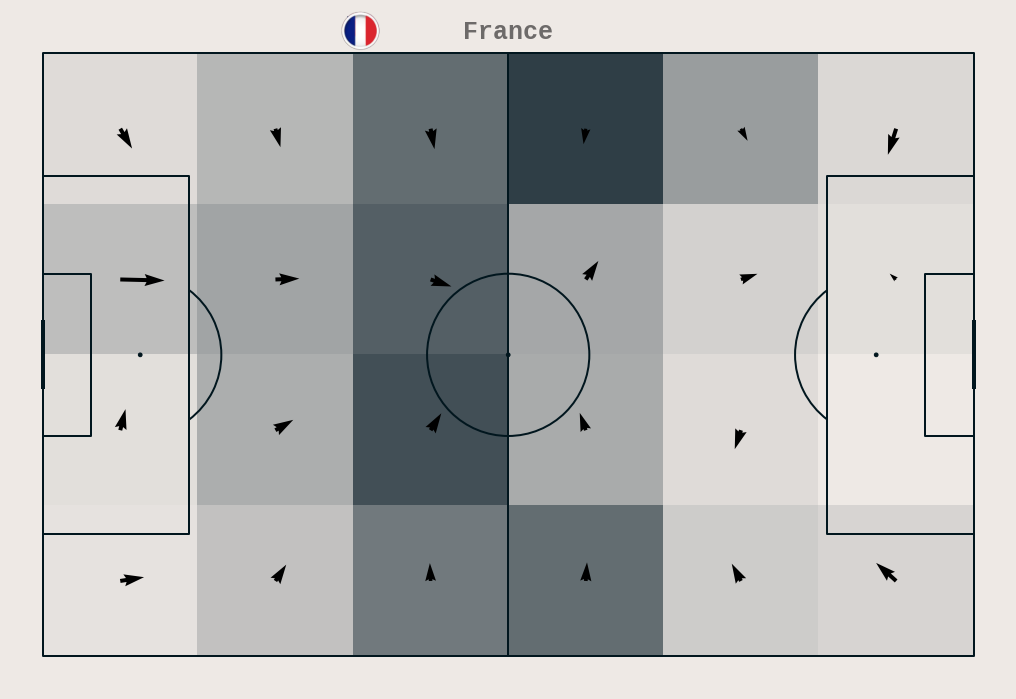

In [ ]:
pass_flow_team(pass_flow_df,'France', 'Argentina-3-3-France')

## `Pass Flow Map | Player`

### **Funcion**

In [ ]:
def pass_flow_player(data,player):
  jugador = player
  team_pass_flow_df = data.query("jugador == @jugador")
  team_pass_flow_df['pos_x'] = pd.to_numeric(data['pos_x'])
  team_pass_flow_df['pos_x_end'] = pd.to_numeric(data['pos_x_end'])
  team_pass_flow_df['pos_y'] = pd.to_numeric(data['pos_y'])
  team_pass_flow_df['pos_y_end'] = pd.to_numeric(data['pos_y_end'])

  pitch = Pitch(pitch_type='custom',
                axis=False,
                pitch_length=105,
                pitch_width=68,
                line_zorder=2,
                pitch_color='#eee9e5',
                line_color='#01161E')
  bins = (6, 4)
  fig, ax = pitch.draw(figsize=(14, 11), constrained_layout=True, tight_layout=False)
  fig.set_facecolor('#eee9e5')

  # plot the heatmap - darker colors = more passes originating from that square
  bs_heatmap = pitch.bin_statistic(team_pass_flow_df.pos_x, 
                                  team_pass_flow_df.pos_y, 
                                  statistic='count', 
                                  bins=bins)
  pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                        ['#eee9e5', '#2f3e46'], N=100)
  hm = pitch.heatmap(bs_heatmap, ax=ax, cmap=pearl_earring_cmap)

  # plot the pass flow map with a single color ('black') and length of the arrow (5)
  fm = pitch.flow(team_pass_flow_df.pos_x, team_pass_flow_df.pos_y, team_pass_flow_df.pos_x_end, team_pass_flow_df.pos_y_end,
                  color='black', 
                  arrow_type='scale',
                  bins=bins, ax=ax)
  
  ax_title = ax.set_title(f'{jugador}', 
                          pad=-20,color='#6d6a69',
                          fontproperties = fontprop ,
                          fontweight = 'bold',
                          fontsize=25)

  '''
  image_home, _ = set_logos(team,team)

  ax_home_logo = add_image(image_home, fig,
                        left=0.33,
                        bottom=0.88,
                        height=0.06)
  '''


  

### **Example**

In [ ]:
pass_flow_player(pass_flow_df,'Ryan Bolanos Davis')

## `Pass Flow Map | All Teams`

### Function

In [ ]:
def pass_flow_all_teams():
  # filtering out some highlight_text warnings - the warnings aren't correct as the
  # text fits inside the axes.
  warnings.simplefilter("ignore", UserWarning)

  teams = main_df['Equipos'].unique()

  pitch = Pitch(pitch_type='custom',
                  axis=False,
                  pitch_length=105,
                  pitch_width=68,
                  line_zorder=2,
                  pitch_color='#eee9e5',
                  line_color='#01161E')
  bins = (6, 4)
  # plot the 5 * 3 grid
  fig, axs = pitch.grid(nrows=4, ncols=3, figheight=30,
                        endnote_height=0.03, endnote_space=0,
                        axis=False,
                        title_height=0.08, grid_height=0.84)
  fig.set_facecolor('#eee9e5')

  for idx, ax in enumerate(axs['pitch'].flat):
    if idx < 12:
      #print(teams[idx])
      team = teams[idx]
      ax_text(0, 72, teams[idx], ha='left', va='center',fontweight = 'bold', fontsize=20,ax=ax)
      pass_df = pass_flow_df.query("Equipos == @team")
      pass_df['pos_x'] = pd.to_numeric(pass_df['pos_x'])
      pass_df['pos_x_end'] = pd.to_numeric(pass_df['pos_x_end'])
      pass_df['pos_y'] = pd.to_numeric(pass_df['pos_y'])
      pass_df['pos_y_end'] = pd.to_numeric(pass_df['pos_y_end'])
      
      # plot the heatmap - darker colors = more passes originating from that square
      bs_heatmap = pitch.bin_statistic(pass_df.pos_x, 
                                      pass_df.pos_y, 
                                      statistic='count', 
                                      bins=bins)
      pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                            ['#eee9e5', '#2f3e46'], N=100)
      hm = pitch.heatmap(bs_heatmap, ax=ax, cmap=pearl_earring_cmap)

      # plot the pass flow map with a single color ('black') and length of the arrow (5)
      fm = pitch.flow(pass_df.pos_x, pass_df.pos_y, pass_df.pos_x_end, pass_df.pos_y_end,
                      color='black', arrow_type='same',
                      arrow_length=5, bins=bins, ax=ax)
      
      
  ######### TITLE SECTION #########
  axs['title'].text(0.5, 0.5, 
                    'Pass Flow Maps | Torneo Apertura 2022',
                    ha='center', 
                    va='center', 
                    fontsize=70, 
                    color='#6d6a69',
                    fontweight = 'bold')
  

    




### Example

In [ ]:
pass_flow_all_teams()


## `Mapa de recuperaciones`

### Funcion

In [ ]:
recuperaciones_df = pd.DataFrame()
perdidas_df = pd.DataFrame()
equipos = main_df['Equipos'].unique()
partidos = main_df['Partido'].unique()
for equipo in equipos:
  temp_df = main_df.query("Equipos == @equipo")
  temp_perdidas_df = temp_df.query("Acciones == 'Perdidas' ")
  perdidas_df = perdidas_df.append(temp_perdidas_df)
  temp_df = main_df.query("Equipos != @equipo")
  temp_recuperaciones_df = temp_df.query("Acciones == 'Perdidas' and rival == @equipo ")
  recuperaciones_df = recuperaciones_df.append(temp_recuperaciones_df)
  #print(len(temp_df),len(perdidas_df),len(recuperaciones_df), equipo)

In [ ]:
def recuperaciones_chart(data,team):
  team = team
  data_df = data.query("rival == @team")
  pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                       ['#eee9e5', '#2f3e46'], N=100)

  path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),path_effects.Normal()]



  pitch = VerticalPitch(pitch_type='custom',
                        axis=False,
                        pitch_length=105,
                        pitch_width=68, 
                        line_zorder=2, 
                        pitch_color='#eee9e5',
                        line_color='#01161E')
  fig, axs = pitch.grid(endnote_height=0.03, 
                        endnote_space=0,
                        title_height=0.08, 
                        title_space=0,
                        figheight=14,
                        # Turn off the endnote/title axis. I usually do this after
                        # I am happy with the chart layout and text placement
                        axis=False,
                        grid_height=0.84)
  fig.set_facecolor('#eee9e5')

  # heatmap and labels
  bin_statistic = pitch.bin_statistic_positional(data_df.pos_x, 
                                                 data_df.pos_y, statistic='count',
                                                 positional='full', normalize=True)
  pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                          cmap=pearl_earring_cmap, edgecolors='#22312b')
  labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                              ax=axs['pitch'], ha='center', va='center',
                              str_format='{:.0%}',fontweight = 'bold',path_effects=path_eff)

  # endnote and title
  axs['endnote'].text(1, 0.5, 'xxx', va='center', ha='right', fontsize=15,
                      color='#dee6ea')
  axs['title'].text(0.5, 0.5, "Zonas de Recuperación de balón \n {}".format(team), color='#6d6a69',
                    va='center', ha='center',fontproperties = fontprop ,fontweight = 'bold',fontsize=25)



  # sphinx_gallery_thumbnail_path = 'gallery/pitch_plots/images/sphx_glr_plot_heatmap_positional_002.png'

  axs["pitch"].invert_yaxis()

  pitch.arrows(105, -2,
              95, -2, width=2, headwidth=10,
              headlength=10, color='red', ax=axs['pitch'])


### Example

In [ ]:
recuperaciones_chart(recuperaciones_df,"Saprissa")

## `Mapa de perdidas`

### Funcion

In [ ]:
def perdidas_chart(data,team):
  team = team
  data_df = data.query("Equipos == @team")

  pearl_earring_cmap = LinearSegmentedColormap.from_list("Pearl Earring - 10 colors",
                                                        ['#eee9e5', '#2f3e46'], N=100)

  path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),
              path_effects.Normal()]


  pitch = VerticalPitch(pitch_type='custom',
                        axis=False,
                        pitch_length=105,
                        pitch_width=68, 
                        line_zorder=2, 
                        pitch_color='#eee9e5',
                        line_color='#01161E')


  fig, axs = pitch.grid(endnote_height=0.03, 
                        endnote_space=0,
                        title_height=0.08, 
                        title_space=0,
                        figheight=14,
                        # Turn off the endnote/title axis. I usually do this after
                        # I am happy with the chart layout and text placement
                        axis=False,
                        grid_height=0.84)
  fig.set_facecolor('#eee9e5')

  # heatmap and labels
  bin_statistic = pitch.bin_statistic_positional(data_df.pos_x, data_df.pos_y, statistic='count',
                                                positional='full', normalize=True)
  pitch.heatmap_positional(bin_statistic, ax=axs['pitch'],
                          cmap=pearl_earring_cmap, edgecolors='#22312b')
  labels = pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=18,
                              ax=axs['pitch'], ha='center', va='center',
                              str_format='{:.0%}', path_effects=path_eff,fontweight = 'bold')

  # endnote and title
  axs['endnote'].text(1, 0.5, '', va='center', ha='right', fontsize=15,
                      color='#dee6ea')
  axs['title'].text(0.5, 0.5, "Zonas de Pérdida de balón \n {}".format(team), color='#6d6a69',
                      va='center', ha='center',fontproperties = fontprop ,fontweight = 'bold',fontsize=25)

  pitch.arrows(5, -2,
              15, -2, width=2, headwidth=10,
              headlength=10, color='red', ax=axs['pitch'])



### Example

In [ ]:
perdidas_chart(perdidas_df,'Saprissa')

In [ ]:
recuperaciones_df

In [ ]:
main_df.query("Partido == 'Deportivo-Saprissa-2-0-Herediano2' ")

In [ ]:
shots_df = pd.read_excel('/content/Qatar2022_shot_location.xlsx')
shots_df.columns

In [ ]:
#create pitch
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#query
mask_england = (main_df.Acciones == 'Tiros') & (main_df.Equipos == 'Qatar')
#finding rows in the df and keeping only necessary columns
df_england = df.loc[mask_england, ['x', 'y', 'outcome_name', "player_name"]]

#plot them - if shot ended with Goal - alpha 1 and add name
#for England
for i, row in df_england.iterrows():
    if row["outcome_name"] == 'Goal':
    #make circle
       pitch.scatter(row.x, row.y, alpha = 1, s = 500, color = "red", ax=ax['pitch'])
       pitch.annotate(row["player_name"], (row.x + 1, row.y - 2), ax=ax['pitch'], fontsize = 12)
    else:
       pitch.scatter(row.x, row.y, alpha = 0.2, s = 500, color = "red", ax=ax['pitch'])

mask_sweden = (df.type_name == 'Shot') & (df.team_name == team2)
df_sweden = df.loc[mask_sweden, ['x', 'y', 'outcome_name', "player_name"]]

#for Sweden we need to revert coordinates
for i, row in df_sweden.iterrows():
    if row["outcome_name"] == 'Goal':
       pitch.scatter(120 - row.x, 80 - row.y, alpha = 1, s = 500, color = "blue", ax=ax['pitch'])
       pitch.annotate(row["player_name"], (120 - row.x + 1, 80 - row.y - 2), ax=ax['pitch'], fontsize = 12)
    else:
       pitch.scatter(120 - row.x, 80 - row.y, alpha = 0.2, s = 500, color = "blue", ax=ax['pitch'])

fig.suptitle("England (red) and Sweden (blue) shots", fontsize = 30)
plt.show()